## Project 5.2 Neural network multi-class classification - obesity type
Key things:  

Data taken from a **[kaggle competition](https://www.kaggle.com/competitions/playground-series-s4e2/overview)**

Non-obvious attributes:
* FAVC - Frequent consumption of high caloric food
* FCVC - Frequency of consumption of vegetables
* NCP - Number of main meals
* CAEC - Consumption of food between meals
* CH20 - Consumption of water daily
* CALC - Consumption of alcohol
* SCC - Calories consumption monitoring
* FAF - Physical activity frequency
* TUE - Time using technology devices
* MTRANS - (method of) Transportation used

(Target) Obesity scores/classes (NObesity) are:
* Underweight Less than 18.5
* Normal 18.5 to 24.9
* Overweight 25.0 to 29.9
* Obesity I 30.0 to 34.9
* Obesity II 35.0 to 39.9
* Obesity III Higher than 40

## Code setup

In [1]:
import pandas as pd
import numpy as np

# tf
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn utils
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

# sklearn preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# sklearn classification metrics
from sklearn.metrics  import (f1_score ,accuracy_score, confusion_matrix,
                            classification_report, ConfusionMatrixDisplay, 
                            roc_curve, precision_recall_curve,
                            auc, make_scorer, recall_score, accuracy_score, precision_score
                            )

from sklearn.ensemble import RandomForestClassifier

#### Datasets

In [17]:
# training dataset - to split into training and validationg
# df_path = '../datasets/obesity/train.csv' # -  original dataset with original columns names
df_path = '../datasets/obesity/train_renamed.csv'
df = pd.read_csv(df_path, index_col=0)

# testing dataset - unfortunately just the training dataset with no correct classes, but interesting
# nonetheless, to get the result you'd need to submit it to the project/competition page 
# test_df_path = '../datasets/obesity/test.csv' # -  original dataset with original columns names
test_df_path = '../datasets/obesity/test_renamed.csv'
test_df = pd.read_csv(test_df_path, index_col=0)

# datasets with sane preprocessing done - no need to repeat, especially for df_eng
# values rounded to sane decimal places
df_eng_path = '../datasets/obesity/train_rounded.csv'
df_eng = pd.read_csv(df_eng_path, index_col=0)

# with categorical columns encoded
df_enc_path = '../datasets/obesity/train_encoded.csv'
df_enc = pd.read_csv(df_enc_path, index_col=0)

### Column renaming to human-readable - commented for notebook rerun ability
plus **nunique** explorations

one time operation, from now on we will be operating on datasets with these changes applied

By scheme of:
* family_history_with_overweight                   -> family_history
* FAVC - Frequent consumption of high caloric food -> high_caloric_cons
* FCVC - Frequency of consumption of vegetables    -> vegetable_freq
* NCP - Number of main meals                       -> main_meals
* CAEC - Consumption of food between meals         -> between_cons
* CH20 - Consumption of water daily                -> water_cons 
* CALC - Consumption of alcohol                    -> alcohol_cons
* SCC - Calories consumption monitoring            -> calorie_monitor
* FAF - Physical activity frequency                -> physical_freq
* TUE - Time using technology devices              -> device_time
* MTRANS - (method of) Transportation used         -> method_trans

Additionally, every column name will be uniformized to lowercase

In [18]:
# df.sample(5)

In [19]:
# df = df.rename(columns = {
#     'family_history_with_overweight': 'family_history',
#     'FAVC': 'high_caloric_cons',
#     'FCVC': 'vegetable_freq',
#     'NCP': 'main_meals',
#     'CAEC': 'between_meals_cons',
#     'CH2O': 'water_cons',
#     'CALC': 'alcohol_cons',
#     'SCC': 'calorie_monitor',
#     'FAF': 'physical_freq',
#     'TUE' : 'device_time',
#     'MTRANS': 'method_trans'
# })

In [20]:
# df.columns = [col.lower() for col in df.columns]

Let's also rename the target column name, from spanish to english

In [21]:
# df = df.rename(columns = {'nobeyesdad': 'obesity_class'})

In [22]:
# df.columns

#### Applying the column name transformations to the test dataset as well

In [23]:
# test_df = test_df.rename(columns = {
#     'family_history_with_overweight': 'family_history',
#     'FAVC': 'high_caloric_cons',
#     'FCVC': 'vegetable_freq',
#     'NCP': 'main_meals',
#     'CAEC': 'between_meals_cons',
#     'CH2O': 'water_cons',
#     'CALC': 'alcohol_cons',
#     'SCC': 'calorie_monitor',
#     'FAF': 'physical_freq',
#     'TUE' : 'device_time',
#     'MTRANS': 'method_trans'
# })

In [24]:
# test_df.columns = [col.lower() for col in test_df.columns]

In [25]:
# test_df.columns

#### Saving the dataframes with new columns names

In [26]:
df.to_csv('../datasets/obesity/train_renamed.csv')
test_df.to_csv('../datasets/obesity/test_renamed.csv')

In [27]:
df.nunique()

gender                   2
age                   1703
height                1833
weight                1979
family_history           2
high_caloric_cons        2
vegetable_freq         934
main_meals             689
between_meals_cons       4
smoke                    2
water_cons            1506
calorie_monitor          2
physical_freq         1360
device_time           1297
alcohol_cons             3
method_trans             5
obesity_class            7
dtype: int64

#### Further nunique explorations

It seems there are many binary columns (2 unique values) - we'll be changing that. But also - what is happening with the age column? 1703 unique values? Surely that's not possible. Let's examine that.

In [28]:
# df['Age']

Ah, it seems the ages, generated for the dataset were either allowed to be float values, or they were taken from the exact date of birth - doubtly necessary.

Let's look at the other columns of high uniqueness of values

In [29]:
# df['Height']

The data is presented in meters - we really need such precision or should rounding to the second decimal place be enough? To improve model generality and learning, a rounding approach will be taken

In [30]:
# df['Weight']

## EDA

#### Head, dtypes, describe, info

In [31]:
df.head()

gender        age    height      weight family_history high_caloric_cons  \
id                                                                             
0     Male  24.443011  1.699998   81.669950            yes               yes   
1   Female  18.000000  1.560000   57.000000            yes               yes   
2   Female  18.000000  1.711460   50.165754            yes               yes   
3   Female  20.952737  1.710730  131.274851            yes               yes   
4     Male  31.641081  1.914186   93.798055            yes               yes   

    vegetable_freq  main_meals between_meals_cons smoke  water_cons  \
id                                                                    
0         2.000000    2.983297          Sometimes    no    2.763573   
1         2.000000    3.000000         Frequently    no    2.000000   
2         1.880534    1.411685          Sometimes    no    1.910378   
3         3.000000    3.000000          Sometimes    no    1.674061   
4         2.679664    1.971472          Sometimes    no    1.979848   

   calorie_monitor  physical_freq  device_time alcohol_cons  \
id                                                            
0               no       0.000000     0.976473    Sometimes   
1               no       1.000000     1.000000           no   
2               no       0.866045     1.673584           no   
3               no       1.467863     0.780199    Sometimes   
4               no       1.967973     0.931721    Sometimes   

             method_trans        obesity_class  
id                                              
0   Public_Transportation  Overweight_Level_II  
1              Automobile        Normal_Weight  
2   Public_Transportation  Insufficient_Weight  
3   Public_Transportation     Obesity_Type_III  
4   Public_Transportation  Overweight_Level_II

In [32]:
df.dtypes

gender                 object
age                   float64
height                float64
weight                float64
family_history         object
high_caloric_cons      object
vegetable_freq        float64
main_meals            float64
between_meals_cons     object
smoke                  object
water_cons            float64
calorie_monitor        object
physical_freq         float64
device_time           float64
alcohol_cons           object
method_trans           object
obesity_class          object
dtype: object

In [33]:
df.describe()

age        height        weight  vegetable_freq    main_meals  \
count  20758.000000  20758.000000  20758.000000    20758.000000  20758.000000   
mean      23.841804      1.700245     87.887768        2.445908      2.761332   
std        5.688072      0.087312     26.379443        0.533218      0.705375   
min       14.000000      1.450000     39.000000        1.000000      1.000000   
25%       20.000000      1.631856     66.000000        2.000000      3.000000   
50%       22.815416      1.700000     84.064875        2.393837      3.000000   
75%       26.000000      1.762887    111.600553        3.000000      3.000000   
max       61.000000      1.975663    165.057269        3.000000      4.000000   

         water_cons  physical_freq   device_time  
count  20758.000000   20758.000000  20758.000000  
mean       2.029418       0.981747      0.616756  
std        0.608467       0.838302      0.602113  
min        1.000000       0.000000      0.000000  
25%        1.792022       0.008013      0.000000  
50%        2.000000       1.000000      0.573887  
75%        2.549617       1.587406      1.000000  
max        3.000000       3.000000      2.000000

The metrics are obviously only being shown for numerical columns

#### Nulls, nuniques

In [34]:
df.isnull().sum()

gender                0
age                   0
height                0
weight                0
family_history        0
high_caloric_cons     0
vegetable_freq        0
main_meals            0
between_meals_cons    0
smoke                 0
water_cons            0
calorie_monitor       0
physical_freq         0
device_time           0
alcohol_cons          0
method_trans          0
obesity_class         0
dtype: int64

No nulls, beautiful

In [35]:
df.nunique()

gender                   2
age                   1703
height                1833
weight                1979
family_history           2
high_caloric_cons        2
vegetable_freq         934
main_meals             689
between_meals_cons       4
smoke                    2
water_cons            1506
calorie_monitor          2
physical_freq         1360
device_time           1297
alcohol_cons             3
method_trans             5
obesity_class            7
dtype: int64

### Data transformations
All in all, the data will be transformed in the following ways:
* The column names will be changed to be more human-readable, whilst maintaining conciseness
* Age and other columns (above) values will be discretized (rounded) - age to integer, the rest to the second decimal place
* columns of type object, if binary or categorical, will be encoded either one-hot, cardinally or whatever's needed

Columns to round to 2:
* height
* weight
* vegetable_freq 
* main_meals
* water_cons
* physical_freq
* device_time

**TO SKIP THESE OPERATIONS**: use **df_eng** for dataframe with columns of reduced precision (sanity) and **df_enc** for columns with proper encodings (one-hot, binary and cardinal)

#### Rounding, scaling, encoding - new dataset variable - df_eng

In [36]:
df_eng = df.copy()

#### Roundng

In [37]:
df_eng['age'] = round(df_eng['age'],0).astype('int')

In [38]:
df_eng.columns

Index(['gender', 'age', 'height', 'weight', 'family_history',
       'high_caloric_cons', 'vegetable_freq', 'main_meals',
       'between_meals_cons', 'smoke', 'water_cons', 'calorie_monitor',
       'physical_freq', 'device_time', 'alcohol_cons', 'method_trans',
       'obesity_class'],
      dtype='object')

In [39]:
to_round_cols = ['height', 'weight', 'vegetable_freq',
                 'main_meals', 'water_cons', 'physical_freq',
                 'device_time']

In [40]:
df_eng[to_round_cols] = round(df_eng[to_round_cols],2)

In [41]:
df_eng['weight'] = round(df['weight'],1)

Let's check the unique values count now

In [42]:
df_eng.nunique()

gender                  2
age                    42
height                 51
weight                718
family_history          2
high_caloric_cons       2
vegetable_freq        190
main_meals            252
between_meals_cons      4
smoke                   2
water_cons            200
calorie_monitor         2
physical_freq         266
device_time           195
alcohol_cons            3
method_trans            5
obesity_class           7
dtype: int64

Much more manageable

In [43]:
df_eng.to_csv('../datasets/obesity/train_rounded.csv')

#### Encoding - new dataframe 'df_enc'

In [44]:
df_enc  = df_eng.copy()

In [45]:
df_enc.sample(5)

gender  age  height  weight family_history high_caloric_cons  \
id                                                                    
4602   Female   21    1.60    45.0             no               yes   
12761    Male   31    1.71    83.0            yes               yes   
2805   Female   17    1.65    58.0             no               yes   
17961  Female   20    1.46    74.8            yes                no   
11444    Male   20    1.72    80.0            yes                no   

       vegetable_freq  main_meals between_meals_cons smoke  water_cons  \
id                                                                       
4602             2.00        3.00          Sometimes    no        2.00   
12761            2.00        1.07          Sometimes    no        1.00   
2805             2.00        3.00         Frequently    no        1.00   
17961            2.29        1.08          Sometimes    no        1.76   
11444            2.00        3.00          Sometimes    no        2.00   

      calorie_monitor  physical_freq  device_time alcohol_cons  \
id                                                               
4602               no           1.00         0.00    Sometimes   
12761              no           1.00         0.00    Sometimes   
2805               no           1.00         0.00    Sometimes   
17961              no           0.68         0.69    Sometimes   
11444              no           1.00         1.00           no   

                method_trans        obesity_class  
id                                                 
4602   Public_Transportation        Normal_Weight  
12761             Automobile  Overweight_Level_II  
2805   Public_Transportation        Normal_Weight  
17961  Public_Transportation  Overweight_Level_II  
11444  Public_Transportation  Overweight_Level_II

##### Yes/no to binary

In [46]:
yesno_cols = ['family_history', 'high_caloric_cons', 'smoke', 'calorie_monitor']

In [47]:
for col in yesno_cols:
    df_enc[col] = df_enc[col].replace({'yes': 1, 'no': 0})

C:\Users\User\AppData\Local\Temp\ipykernel_9040\2871793080.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_enc[col] = df_enc[col].replace({'yes': 1, 'no': 0})


##### One hot

In [48]:
one_hot_cols = ['gender', 'method_trans']

In [49]:
df_enc = pd.get_dummies(df_enc, columns = one_hot_cols)

##### cardinal columns

In [50]:
df_enc['between_meals_cons'].unique()

array(['Sometimes', 'Frequently', 'no', 'Always'], dtype=object)

In [51]:
df_enc['alcohol_cons'].unique()

array(['Sometimes', 'no', 'Frequently'], dtype=object)

In [52]:
df_enc['between_meals_cons'] = df_enc['between_meals_cons'].map(
    {
        'no': 0,
        'Sometimes': 1,
        'Frequently': 2,
        'Always': 3
    }
)

In [53]:
df_enc['alcohol_cons'] = df_enc['alcohol_cons'].map(
    {
        'no': 0,
        'Sometimes': 1,
        'Frequently': 2
    }
)

##### The result

In [54]:
df_enc.sample(5)

age  height  weight  family_history  high_caloric_cons  vegetable_freq  \
id                                                                              
4688    21    1.77   133.9               1                  1             3.0   
4676    22    1.72    62.0               1                  1             2.0   
16274   22    1.71   132.9               1                  1             3.0   
10937   19    1.70    72.0               0                  1             2.0   
13853   22    1.65    82.0               1                  1             1.0   

       main_meals  between_meals_cons  smoke  water_cons  ...  device_time  \
id                                                        ...                
4688          3.0                   1      0        2.87  ...         0.92   
4676          3.0                   1      0        2.00  ...         1.00   
16274         3.0                   1      0        1.62  ...         0.91   
10937         3.0                   1      0        2.00  ...         1.00   
13853         1.0                   1      0        2.00  ...         2.00   

       alcohol_cons     obesity_class  gender_Female gender_Male  \
id                                                                 
4688              1  Obesity_Type_III           True       False   
4676              1     Normal_Weight          False        True   
16274             1  Obesity_Type_III           True       False   
10937             1     Normal_Weight          False        True   
13853             1    Obesity_Type_I           True       False   

       method_trans_Automobile  method_trans_Bike  method_trans_Motorbike  \
id                                                                          
4688                     False              False                   False   
4676                     False              False                   False   
16274                    False              False                   False   
10937                    False              False                   False   
13853                    False              False                   False   

       method_trans_Public_Transportation  method_trans_Walking  
id                                                               
4688                                 True                 False  
4676                                 True                 False  
16274                                True                 False  
10937                                True                 False  
13853                                True                 False  

[5 rows x 22 columns]

In [55]:
df_enc.dtypes

age                                     int32
height                                float64
weight                                float64
family_history                          int64
high_caloric_cons                       int64
vegetable_freq                        float64
main_meals                            float64
between_meals_cons                      int64
smoke                                   int64
water_cons                            float64
calorie_monitor                         int64
physical_freq                         float64
device_time                           float64
alcohol_cons                            int64
obesity_class                          object
gender_Female                            bool
gender_Male                              bool
method_trans_Automobile                  bool
method_trans_Bike                        bool
method_trans_Motorbike                   bool
method_trans_Public_Transportation       bool
method_trans_Walking              

#### Saving the encoded format to new dataframe file

In [56]:
df_enc.to_csv('../datasets/obesity/train_encoded.csv')

### Data distributions
What can the distributions of data tell us about the fitness of the dataset to be estimated on / how likely is it for attempts at creating predictive models to be successful? Which factors have the potential to aid in that etc

Target distribution

In [57]:
df_eng['obesity_class'].value_counts()

obesity_class
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: count, dtype: int64

Very healthy, should provide many examples to learn on for each class

In [58]:
# fig, ax = plt.subplots(1,1, figsize = (7,7))
# sns.histplot(data = df_eng['obesity_class'], ax=ax)
# ax.tick_params(axis='x', labelrotation=-90)

Let's look at non-encoded columns for clearly labeled distributions

In [59]:
eng_cols = df_eng.columns
eng_cols = [col for col in eng_cols if col != 'obesity_class']

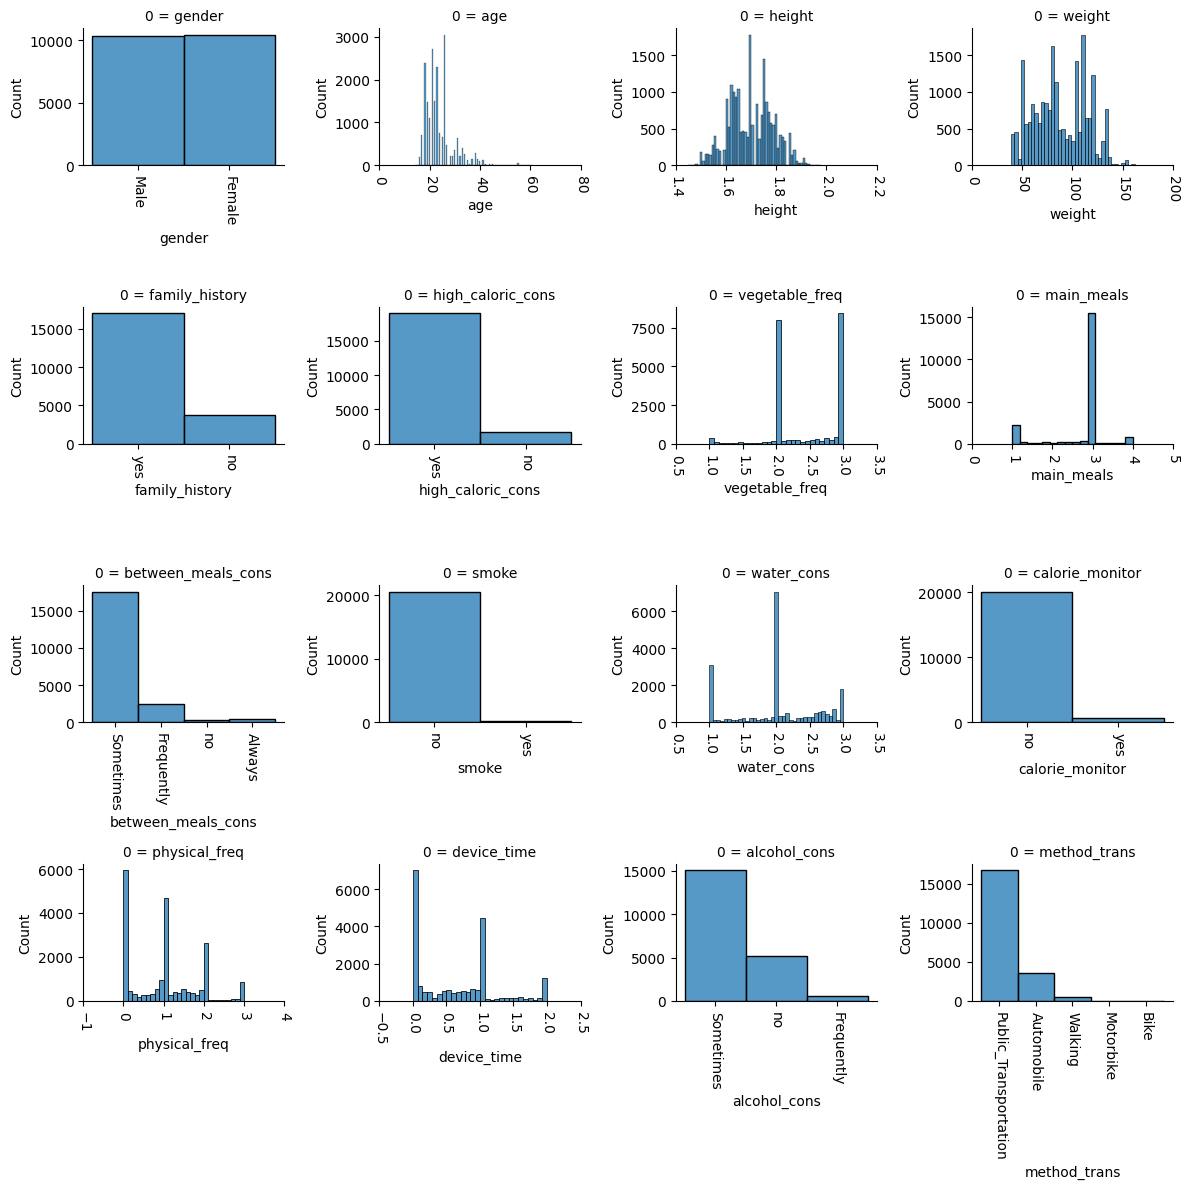

In [60]:
g = sns.FacetGrid(pd.DataFrame(list(eng_cols)), col=0, col_wrap=4, sharex=False, sharey=False)
for ax, col in zip(g.axes, list(eng_cols)):
    sns.histplot(df_eng[col], ax=ax)
g.set_xticklabels(rotation=-90)
g.tight_layout()

What can we tell from just the distributions?
* for smoke, calorie_monitor, almost all of the datapoints belong to one category, rendering them very likely to be useless, unless there's a clear correlation with one or two of the target classes
* for factors like vegetable_freq, main_meals and others, there seems to be a strong "pull" to stiff integer values, which means it might be worth exploring indeed rounding their valeus to integer or perhaps the trainied models will pick this up themselves
* age, height and weight, which seem like the most obvious factors to be used in determining the obesity class seem to have rather healthy distributions

### Relations between the factors and target (obesity class)
To make the analysis visually more feasible, let's group the classess, as seen below

In [61]:
df_eng['obesity_class'].unique()

array(['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight',
       'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I',
       'Obesity_Type_I'], dtype=object)

In [62]:
# Insufficient_Weight
df_under = df_eng[df_eng['obesity_class'] == 'Insufficient_Weight']

# Normal_Weight
df_normal = df_eng[df_eng['obesity_class'] == 'Normal_Weight']

# Overweight
df_over = df_eng[df_eng['obesity_class'].isin(['Overweight_Level_I', 'Overweight_Level_II'])]

# Obesity
df_obesity = df_eng[df_eng['obesity_class'].isin(['Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'])]

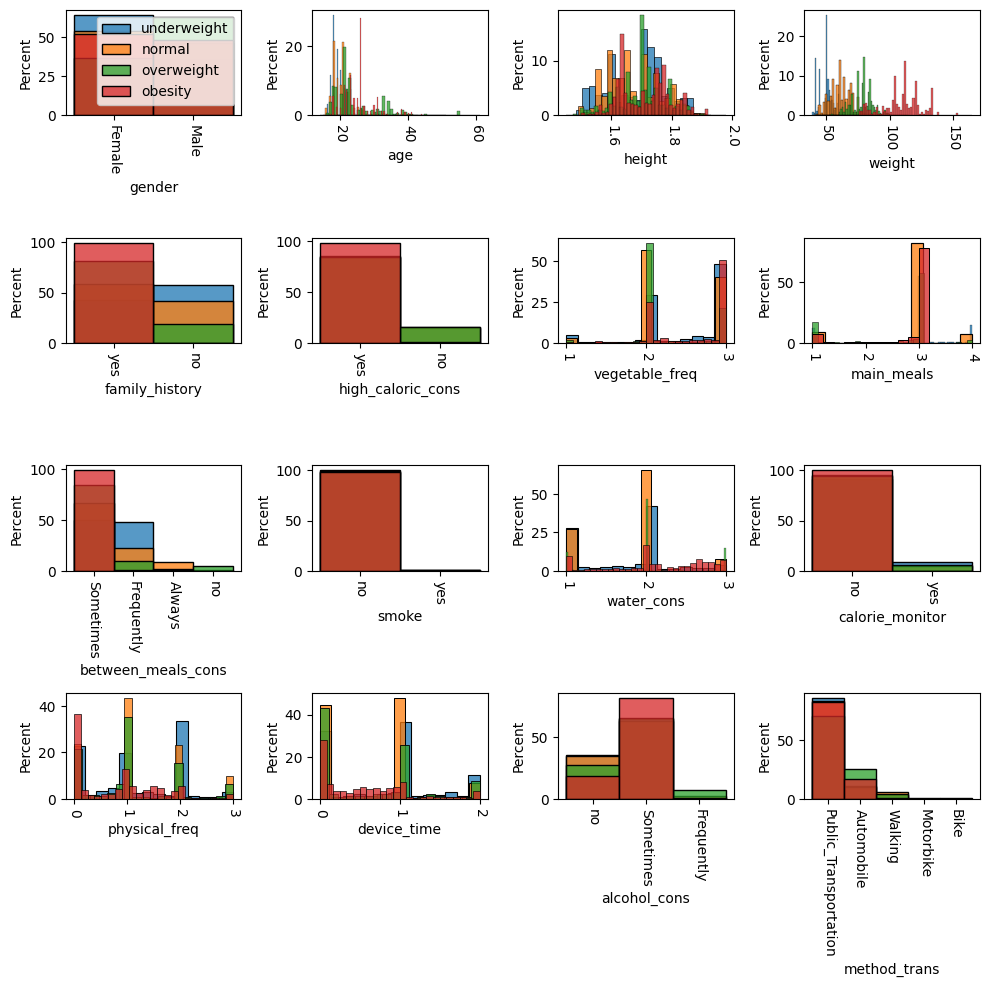

In [63]:
fig, axes = plt.subplots(4,4, figsize = (10,10))
ax = axes.ravel()

for i in range(16):
    sns.histplot(data = df_under, x = eng_cols[i], stat = 'percent', ax=ax[i])
    sns.histplot(data = df_normal, x = eng_cols[i], stat = 'percent', ax=ax[i])
    sns.histplot(data = df_over, x = eng_cols[i], stat = 'percent', ax=ax[i])
    sns.histplot(data = df_obesity, x = eng_cols[i], stat = 'percent', ax=ax[i])
    ax[i].tick_params(axis='x', labelrotation=-90)


ax[0].legend(['underweight', 'normal', 'overweight', 'obesity'])
fig.tight_layout()

What can we conclude from this:
* gender seems to have only a slight correlation with obesity class - typically (in this dataset at least) women are more likely to be in t he 'underweight' range, while men in 'overweight', with an even split in 'obese' classes
* a family history of obesity seems to be positively correlated with obesity. The same goes for consumption of high caloric foods and not monitoring calorie intake
* Smoking status is of absolutely no relation to obesity class

### Dropping clearly useless factors
Out of these rather superficial explorations the factors that clearly don't contribute to the prediction of obesity class are:
* 'smoke'

While some other, potentially unnecessary factors include:
* 'calorie_monitor' - too skewed, potentially unrelated, a lot of overlap
* 'method_trans' - too skewed, potentially unrelated, a lot of overlap
* 'age', 'height' - a lot of overlap between classes
* 'alcohol_cons' - also a lot of overlap

In [64]:
df_enc = df_enc.drop(['smoke'], axis=1)
df_eng = df_eng.drop(['smoke'], axis=1)

### Train-test-split - X_train, X_valid, y_train, y_valid
As the testing doesn't include target values, we'll create our own testing dataset, to set aside and test the models on after all the finetuning has been done on the train and validation sets

In [65]:
X = df_enc.drop(['obesity_class'], axis=1)
y = pd.DataFrame(df_enc['obesity_class'])

In [66]:
X.shape

(20758, 20)

#### setting out the test set

In [67]:
X_1, X_test, y_1, y_test = train_test_split(X,y, test_size = 0.1, shuffle=True, stratify=y)

In [68]:
X_test.shape

(2076, 20)

#### train and validation sets

In [69]:
X_train, X_valid, y_train, y_valid = train_test_split(X_1, y_1, test_size = 0.2, shuffle=True, stratify=y_1)

In [70]:
X_train.shape

(14945, 20)

In [71]:
X_valid.shape

(3737, 20)

### Random forests
For now, let's try working without scaling the data

In [72]:
rf_model = RandomForestClassifier()

In [73]:
rf_model.fit(X_train, y_train)

C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [74]:
rf_preds = rf_model.predict(X_valid)

In [75]:
# # sklearn classification metrics
# from sklearn.metrics  import (f1_score ,accuracy_score, confusion_matrix,
#                             classification_report, ConfusionMatrixDisplay, 
#                             roc_curve, precision_recall_curve,
#                             auc, make_scorer, recall_score, accuracy_score, precision_score
#                             )

In [76]:
rf_report = classification_report(y_valid, rf_preds)
print(rf_report)

                     precision    recall  f1-score   support

Insufficient_Weight       0.91      0.91      0.91       454
      Normal_Weight       0.82      0.87      0.84       555
     Obesity_Type_I       0.90      0.88      0.89       524
    Obesity_Type_II       0.98      0.97      0.98       585
   Obesity_Type_III       1.00      1.00      1.00       728
 Overweight_Level_I       0.82      0.73      0.77       437
Overweight_Level_II       0.79      0.84      0.82       454

           accuracy                           0.90      3737
          macro avg       0.89      0.88      0.89      3737
       weighted avg       0.90      0.90      0.90      3737



A general accuracy of about 90%, not bad, though the recall for 'overweight' classes is noticeably lower than for the other classes

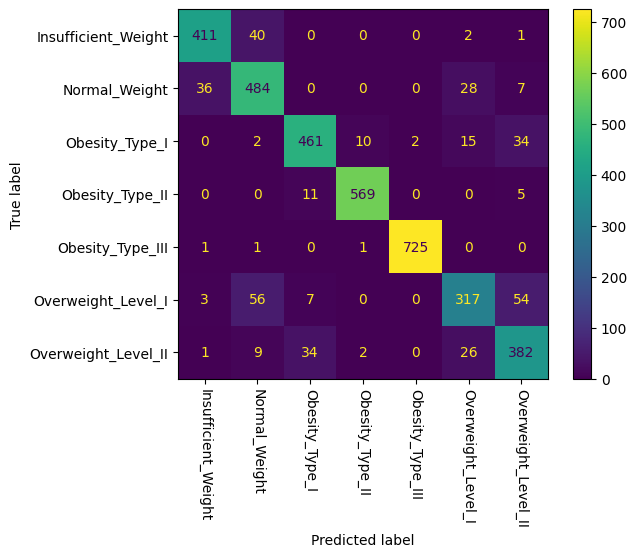

In [77]:
rf_cm = confusion_matrix(y_valid, rf_preds)
rf_cm_disp = ConfusionMatrixDisplay(rf_cm, display_labels = rf_model.classes_)
rf_cm_disp.plot(xticks_rotation=-90)

Perhaps unsurprisingly, the model most often seems to consufe normal weight with insuficient, or overweight classes, as they are much closer (see the top of the project for class value ranges) to each other, than to 'obese' classes

Whilst these results seem very promising indeed and we could try to either tune the random forest model further or attempt classification with other 'classical' ML models, the goal of this project is to explore neural network solutions for different kinds of problems, therefore that is what we will do

#### Before proceeding to NN models - let's explore forest feature importance
That is, let's see which factors the model thought to eb most important for predicting the target class.

For further insformation see: **[docs](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)**

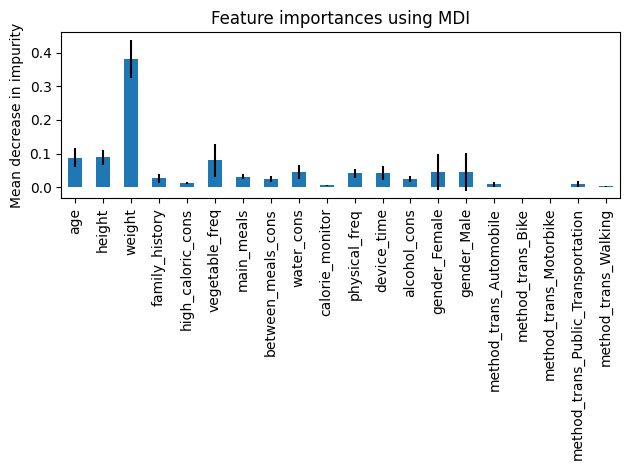

In [78]:
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

feature_names = list(X.columns)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Indeed it seems the weight is the predominant factor, whilst the influence of transportation methods is near zero - we will consider dropping these methods later on

### First NN model

### Important! Changing the labels to numerical?
So that we can be sure of the order of the classes after any splitting, modeling etc work done - that is - if the labels are in numerical form ranging from 0-6, instead of string, so that their ordering is obvious and repeatable

In [79]:
y['obesity_class'].unique()

array(['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight',
       'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I',
       'Obesity_Type_I'], dtype=object)

In [80]:
X = df_enc.drop(['obesity_class'], axis=1)
y = pd.DataFrame(df_enc['obesity_class'])
y['obesity_class'] = y['obesity_class']. map({
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
})

In [81]:
class_names = [
    'Insufficient_Weight',
    'Normal_Weight',
    'Overweight_Level_I',
    'Overweight_Level_II',
    'Obesity_Type_I',
    'Obesity_Type_II',
    'Obesity_Type_III'
]

#### splitting with the new target labels

In [82]:
X_1, X_test, y_1, y_test = train_test_split(X,y, test_size = 0.1, shuffle=True, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_1, y_1, test_size = 0.2, shuffle=True, stratify=y_1)

In [88]:
n_classes = y.nunique().values[0]
class_numbers = list(y['obesity_class'].unique())
print(n_classes)
print(class_names)
print(sorted(class_numbers))

7
['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']
[0, 1, 2, 3, 4, 5, 6]


### Scaling the data to 0-1 range
As established in previous projects and typically recommended, or even expected, the input values should be limited to a small range, for optimal training, typically 0-1 or -1,1 (mean 0, std 1). Let's start with 0-1

As per best practices (avoiding contaminating the validation data), the scaling algorithms will be fitted on the training data only

In [89]:
X_cols = list(X.columns)
y_col = ['obesity_class']

In [90]:
scaler_X = MinMaxScaler()
scaler_X.fit(X_train[X_cols])
# scaler_y = MinMaxScaler()
# scaler_y.fit(y_train)

X_train[X_cols] = scaler_X.transform(X_train[X_cols])
X_valid[X_cols] = scaler_X.transform(X_valid[X_cols])

In [91]:
n_features = len(X_cols)
n_features

20

In [92]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=[n_features]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

In [93]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [94]:
history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=20)

Epoch 1/20


468/468 [==============================] - 1s 2ms/step - loss: 1.0183 - accuracy: 0.6005 - val_loss: 0.6180 - val_accuracy: 0.7798
Epoch 2/20
468/468 [==============================] - 1s 1ms/step - loss: 0.6136 - accuracy: 0.7590 - val_loss: 0.4902 - val_accuracy: 0.8162
Epoch 3/20
468/468 [==============================] - 1s 1ms/step - loss: 0.5308 - accuracy: 0.7930 - val_loss: 0.4316 - val_accuracy: 0.8609
Epoch 4/20
468/468 [==============================] - 1s 1ms/step - loss: 0.4872 - accuracy: 0.8181 - val_loss: 0.4183 - val_accuracy: 0.8595
Epoch 5/20
468/468 [==============================] - 1s 1ms/step - loss: 0.4648 - accuracy: 0.8294 - val_loss: 0.4289 - val_accuracy: 0.8515
Epoch 6/20
468/468 [==============================] - 1s 1ms/step - loss: 0.4511 - accuracy: 0.8371 - val_loss: 0.4064 - val_accuracy: 0.8622
Epoch 7/20
468/468 [==============================] - 1s 1ms/step - loss: 0.4404 - accuracy: 0.8390 - val_loss: 0.3974 - val_accuracy: 0.8686
Epoc

In [95]:
history_df = pd.DataFrame(history.history)

In [96]:
history_df.head()

loss  accuracy  val_loss  val_accuracy
0  1.018330  0.600535  0.617980      0.779770
1  0.613569  0.759050  0.490180      0.816163
2  0.530752  0.792974  0.431630      0.860851
3  0.487218  0.818133  0.418328      0.859513
4  0.464836  0.829374  0.428869      0.851485

C:\Users\User\AppData\Local\Temp\ipykernel_9040\1283135118.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


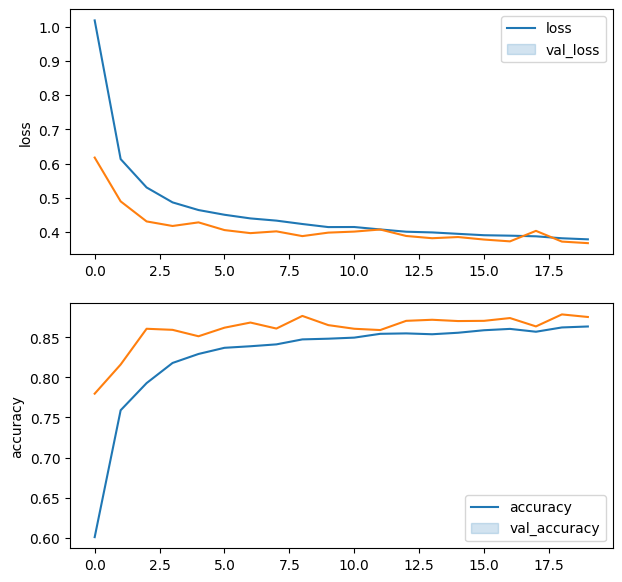

In [97]:
fig, axes = plt.subplots(2,1, figsize = (7,7))
ax = axes.ravel()
sns.lineplot(history_df['loss'], ax=ax[0])
sns.lineplot(history_df['val_loss'], ax=ax[0])
sns.lineplot(history_df['accuracy'], ax=ax[1])
sns.lineplot(history_df['val_accuracy'], ax=ax[1])
ax[0].legend(['loss', 'val_loss'])
ax[1].legend(['accuracy', 'val_accuracy'])
fig.show()

In [98]:
y_preds = model.predict(X_valid)

117/117 [==============================] - 0s 629us/step


In [99]:
y_preds[0]

array([5.8124059e-21, 9.9922295e-13, 1.9866532e-07, 5.3210415e-06,
       3.0350583e-03, 3.3455181e-06, 9.9695599e-01], dtype=float32)

In [100]:
y_preds_argmax = y_preds.argmax(axis=1)
y_preds_argmax.shape

(3737,)

In [101]:
valid_df = pd.DataFrame()

In [102]:
valid_df = X_valid.copy()

In [103]:
valid_df['y_true'] = y_valid

In [104]:
valid_df['y_pred'] = y_preds_argmax

In [105]:
preds_df = pd.DataFrame(y_preds)

In [106]:
preds_df

0             1             2             3             4  \
0     5.812406e-21  9.992229e-13  1.986653e-07  5.321041e-06  3.035058e-03   
1     3.986756e-05  1.219355e-03  4.262536e-02  9.470844e-01  8.120325e-03   
2     5.703445e-22  2.806867e-14  3.485140e-08  1.440410e-05  3.656003e-03   
3     2.848661e-03  9.357643e-01  6.094314e-02  4.234313e-04  1.972122e-05   
4     2.061612e-24  3.924092e-15  6.197679e-09  2.793857e-07  4.294117e-04   
...            ...           ...           ...           ...           ...   
3732  9.750841e-01  2.463233e-02  2.834131e-04  1.404054e-07  3.594496e-09   
3733  1.839943e-14  2.709271e-08  4.971924e-04  2.717655e-02  9.322328e-01   
3734  1.453087e-29  3.969391e-18  1.205911e-10  1.987648e-08  1.620493e-04   
3735  5.346584e-02  9.309813e-01  1.548934e-02  5.719124e-05  6.402181e-06   
3736  4.751497e-15  9.641767e-09  1.116783e-04  9.070473e-03  9.753488e-01   

                 5             6  
0     3.345518e-06  9.969560e-01  
1     9.017501e-04  8.917995e-06  
2     9.962078e-01  1.217861e-04  
3     6.462911e-09  8.142994e-07  
4     4.853757e-07  9.995698e-01  
...            ...           ...  
3732  9.450813e-14  7.231845e-10  
3733  3.983555e-02  2.579661e-04  
3734  1.672889e-07  9.998376e-01  
3735  1.610974e-11  1.356703e-08  
3736  1.533048e-02  1.386721e-04  

[3737 rows x 7 columns]

In [107]:
valid_df = valid_df.reset_index()

In [108]:
valid_df = pd.concat([valid_df, preds_df], axis=1)

In [109]:
valid_df.sample(5)

id       age    height    weight  family_history  high_caloric_cons  \
1526   1291  0.085106  0.547170  0.087232             1.0                1.0   
625    2976  0.425532  0.396226  0.404441             1.0                0.0   
2810    594  0.063830  0.660377  0.166534             1.0                1.0   
3139  10872  0.085106  0.471698  0.325139             1.0                1.0   
2489   7201  0.106383  0.754717  0.176844             1.0                1.0   

      vegetable_freq  main_meals  between_meals_cons  water_cons  ...  \
1526            0.26    0.666667            0.333333         0.0  ...   
625             1.00    0.000000            0.333333         0.0  ...   
2810            0.50    0.666667            1.000000         0.5  ...   
3139            0.50    0.666667            0.333333         0.5  ...   
2489            1.00    0.723333            0.333333         0.5  ...   

      method_trans_Walking  y_true  y_pred             0         1         2  \
1526                   0.0       2       0  9.504491e-01  0.048888  0.000662   
625                    0.0       5       5  2.216578e-10  0.000001  0.002423   
2810                   0.0       1       1  3.122445e-01  0.673637  0.014098   
3139                   0.0       3       3  9.127229e-07  0.003312  0.122517   
2489                   0.0       0       0  6.276799e-01  0.369988  0.002331   

                 3             4             5             6  
1526  6.215146e-07  7.646536e-08  5.994166e-13  3.900841e-10  
625   3.176109e-01  9.322266e-02  5.860474e-01  6.948949e-04  
2810  1.753957e-05  2.966353e-06  7.136083e-11  3.231475e-08  
3139  5.803680e-01  2.937759e-01  1.466600e-05  1.147497e-05  
2489  1.265772e-06  6.080841e-08  2.626725e-12  4.458206e-09  

[5 rows x 30 columns]

### NN classification report, confusion matrix, further examination of errors

In [110]:
nn_clf_report = classification_report(y_valid, y_preds_argmax, target_names = class_names)
print(nn_clf_report)

                     precision    recall  f1-score   support

Insufficient_Weight       0.91      0.91      0.91       454
      Normal_Weight       0.83      0.87      0.85       555
 Overweight_Level_I       0.73      0.73      0.73       437
Overweight_Level_II       0.79      0.71      0.75       454
     Obesity_Type_I       0.84      0.86      0.85       524
    Obesity_Type_II       0.95      0.96      0.95       585
   Obesity_Type_III       0.99      0.99      0.99       728

           accuracy                           0.88      3737
          macro avg       0.86      0.86      0.86      3737
       weighted avg       0.88      0.88      0.87      3737



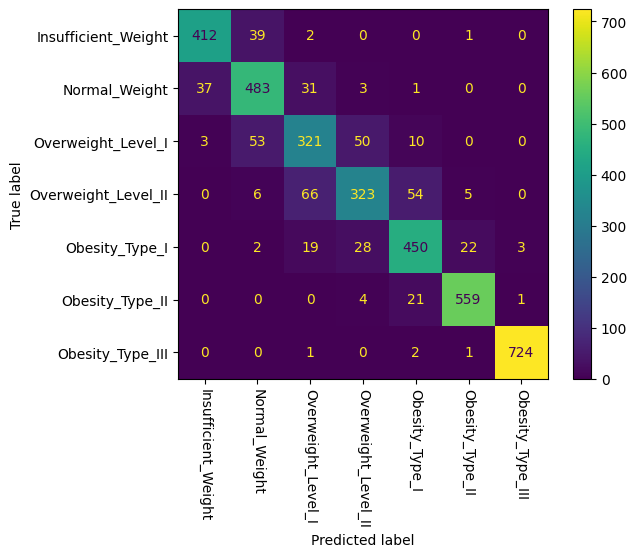

In [111]:
nn_cm = confusion_matrix(y_valid, y_preds_argmax)
nn_cm_disp = ConfusionMatrixDisplay(nn_cm, display_labels = class_names)
nn_cm_disp.plot(xticks_rotation=-90)

Alas, it seems the model was especially useful in classifying extreme (obesity) cases, but struggled a bit more in the intermediary class differentiation.

Let's try to look at the difference in characteristics between the right and wrong predictions

In [112]:
wrong_df = valid_df[valid_df['y_true'] != valid_df['y_pred']]
print(f'wrong shape: {wrong_df.shape}')
right_df = valid_df[valid_df['y_true'] == valid_df['y_pred']]
print(f'right shape: {right_df.shape}')

wrong shape: (465, 30)
right shape: (3272, 30)


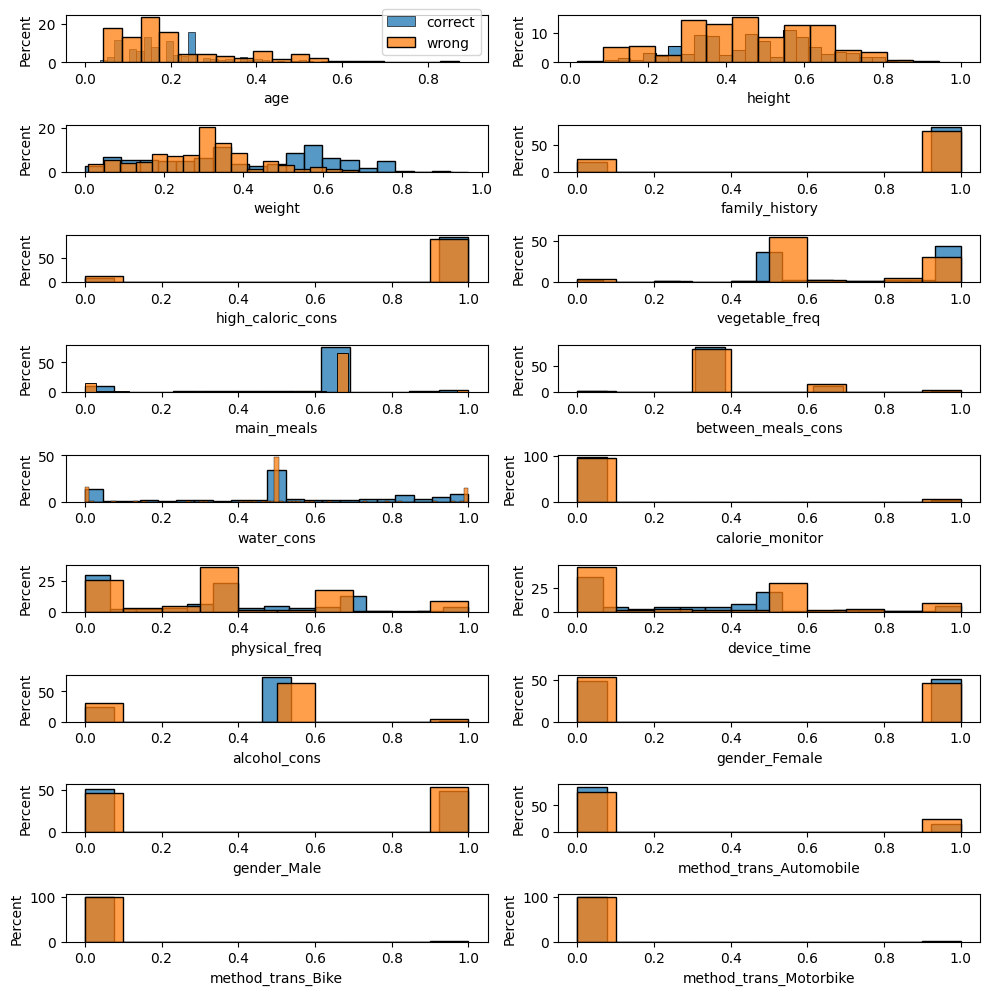

In [113]:
fig, axes = plt.subplots(9,2, figsize=(10,10))
right_wrong_cols = [*X_cols, 'y_true', 'y_pred']

ax = axes.ravel()

for i in range(18):
    # sns.histplot(data=df, x=cols_no_stroke[i], hue='stroke', stat='density', ax=ax[i])
    sns.histplot(data = right_df, x=right_wrong_cols[i], stat='percent', ax=ax[i])
    sns.histplot(data = wrong_df, x=right_wrong_cols[i], stat='percent', ax=ax[i])
ax[0].legend(['correct', 'wrong'], loc='best')
fig.tight_layout()

#### Worst performing class?

In [114]:
valid_df['correct'] = (valid_df['y_true'] == valid_df['y_pred'])

In [115]:
valid_df[valid_df['correct'] == False].groupby(by=['y_true']).mean()

id       age    height    weight  family_history  \
y_true                                                               
0       11776.547619  0.144883  0.394429  0.127393        0.547619   
1       10008.708333  0.143913  0.409591  0.179322        0.527778   
2       10619.879310  0.228907  0.427944  0.273545        0.681034   
3       11189.396947  0.231444  0.474867  0.345116        0.877863   
4       10992.716216  0.273433  0.506884  0.421512        0.932432   
5       14042.423077  0.272504  0.566038  0.510401        1.000000   
6       11197.750000  0.180851  0.391509  0.376883        1.000000   

        high_caloric_cons  vegetable_freq  main_meals  between_meals_cons  \
y_true                                                                      
0                0.928571        0.640476    0.679762            0.507937   
1                0.888889        0.715486    0.578704            0.444444   
2                0.775862        0.673750    0.549655            0.416667   
3                0.916031        0.619618    0.508499            0.386768   
4                0.945946        0.635270    0.494459            0.360360   
5                0.884615        0.621154    0.430000            0.346154   
6                1.000000        1.000000    0.666667            0.333333   

        water_cons  ...  method_trans_Walking    y_pred             0  \
y_true              ...                                                 
0         0.333690  ...              0.095238  1.142857  2.995547e-01   
1         0.381944  ...              0.041667  1.041667  3.789119e-01   
2         0.570517  ...              0.077586  2.094828  2.466534e-02   
3         0.534313  ...              0.015267  2.893130  5.112811e-04   
4         0.528514  ...              0.013514  3.405405  4.704131e-03   
5         0.484423  ...              0.038462  3.923077  9.465933e-07   
6         0.460000  ...              0.000000  3.750000  3.735067e-06   

               1         2         3         4         5         6  correct  
y_true                                                                       
0       0.623598  0.048092  0.004290  0.005545  0.018913  0.000006      0.0  
1       0.250242  0.291651  0.059438  0.019606  0.000057  0.000094      0.0  
2       0.338551  0.244167  0.294780  0.096752  0.000787  0.000297      0.0  
3       0.059691  0.347141  0.246417  0.310152  0.035529  0.000559      0.0  
4       0.029322  0.208630  0.301154  0.170109  0.247843  0.038238      0.0  
5       0.000087  0.013466  0.135100  0.616314  0.188840  0.046191      0.0  
6       0.079588  0.180872  0.038636  0.510619  0.159981  0.030301      0.0  

[7 rows x 30 columns]

## TODO: improvement of results
* less features
* actual analysis of above differences?
* 

#### Sample of wrong predictions

In [116]:
wrong_sample = wrong_df.sample(10)
wrong_sample = wrong_sample.reset_index()
wrong_sample

index     id       age    height    weight  family_history  \
0    168  14383  0.191489  0.622642  0.325139             1.0   
1   2615   7322  0.085106  0.283019  0.229976             1.0   
2   1701  15535  0.170213  0.547170  0.340999             1.0   
3    528   7163  0.148936  0.094340  0.023791             0.0   
4    428  15712  0.404255  0.471698  0.348929             0.0   
5   3616  12640  0.191489  0.452830  0.285488             1.0   
6   2347  20271  0.255319  0.471698  0.512292             1.0   
7   2790  11609  0.106383  0.207547  0.325139             0.0   
8     75   5341  0.085106  0.660377  0.229976             0.0   
9   1375  10157  0.170213  0.358491  0.084853             1.0   

   high_caloric_cons  vegetable_freq  main_meals  between_meals_cons  ...  \
0                1.0            0.50    0.666667            0.666667  ...   
1                1.0            0.50    0.000000            0.333333  ...   
2                1.0            0.50    0.573333            0.333333  ...   
3                1.0            1.00    0.000000            0.333333  ...   
4                1.0            0.50    0.666667            0.000000  ...   
5                0.0            0.50    0.666667            0.333333  ...   
6                1.0            0.50    0.043333            0.333333  ...   
7                1.0            0.50    0.043333            0.333333  ...   
8                1.0            0.00    0.666667            0.333333  ...   
9                1.0            0.17    0.666667            0.333333  ...   

   method_trans_Walking  y_true  y_pred             0             1         2  \
0                   0.0       3       2  1.543393e-05  3.210931e-01  0.493296   
1                   0.0       3       2  9.981359e-06  8.595762e-02  0.716270   
2                   0.0       3       2  1.288514e-08  3.452783e-03  0.573307   
3                   0.0       1       0  9.517133e-01  4.604891e-02  0.002237   
4                   1.0       2       3  2.084153e-08  1.707450e-03  0.417170   
5                   0.0       2       3  6.233919e-06  1.075975e-01  0.391837   
6                   0.0       3       5  1.919313e-18  3.712691e-11  0.000003   
7                   0.0       2       4  2.781446e-10  5.768831e-05  0.058783   
8                   0.0       2       1  4.859382e-03  9.454570e-01  0.049588   
9                   0.0       0       1  3.838774e-01  6.089401e-01  0.007170   

              3             4             5             6  
0  1.632495e-01  2.209739e-02  7.829080e-05  1.705663e-04  
1  1.667442e-01  3.101614e-02  4.368202e-07  1.590111e-06  
2  4.021794e-01  2.088574e-02  6.969770e-05  1.055680e-04  
3  4.283906e-07  4.088431e-08  7.553888e-12  2.213513e-08  
4  5.606471e-01  2.022369e-02  1.511610e-04  1.009300e-04  
5  4.958092e-01  4.636600e-03  5.527518e-05  5.790486e-05  
6  1.646803e-03  1.224759e-01  8.756681e-01  2.059164e-04  
7  6.643444e-02  8.722755e-01  3.407948e-04  2.108586e-03  
8  8.373042e-05  1.162113e-05  3.885794e-11  1.695597e-08  
9  1.189589e-05  9.954670e-07  5.187819e-12  3.991759e-09  

[10 rows x 31 columns]

In [117]:
# fig, ax = plt.subplots(1,1, figsize=(1,1))
# sns.barplot(wrong_sample.loc[0, 0:6], ax=ax)
# # wrong_sample.loc[0, 0:6]
# fig.show()

## A Bigger model? - function for quick model testing

In [141]:
def test_clf_model(model, callbacks, X_train, X_valid, y_train, y_valid, epochs = 50, batch_size = 32):
    """
    Trains a compiled model, calculates predictions and metrics, plots learning curves, metrics etc
    ---
    Params:
        model
        callbacks - array of callbacks for fitting
        # metrics - array of metric functions or names
        X_train
        X_valid
        y_train
        y_valid
        epochs
    """
    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=epochs,
        batch_size = batch_size,
        callbacks = callbacks,
        verbose = False
    )

    history_df = pd.DataFrame(history.history)

    fig, axes = plt.subplots(2,1, figsize = (7,7))
    ax = axes.ravel()
    sns.lineplot(history_df['loss'], ax=ax[0])
    sns.lineplot(history_df['val_loss'], ax=ax[0])
    sns.lineplot(history_df['accuracy'], ax=ax[1])
    sns.lineplot(history_df['val_accuracy'], ax=ax[1])
    ax[0].legend(['loss', 'val_loss'])
    ax[1].legend(['accuracy', 'val_accuracy'])
    fig.show()

    y_preds = model.predict(X_valid)
    y_preds_argmax = y_preds.argmax(axis=1)
    valid_df = X_valid.copy()
    valid_df['y_true'] = y_valid
    valid_df['y_pred'] = y_preds_argmax
    preds_df = pd.DataFrame(y_preds)
    valid_df = valid_df.reset_index()
    valid_df = pd.concat([valid_df, preds_df], axis=1)

    nn_clf_report = classification_report(y_valid, y_preds_argmax, target_names = class_names)
    print(nn_clf_report)

    nn_cm = confusion_matrix(y_valid, y_preds_argmax)
    nn_cm_disp = ConfusionMatrixDisplay(nn_cm, display_labels = class_names)
    nn_cm_disp.plot(xticks_rotation=-90)

    wrong_df = valid_df[valid_df['y_true'] != valid_df['y_pred']]
    print(f'wrong shape: {wrong_df.shape}')
    right_df = valid_df[valid_df['y_true'] == valid_df['y_pred']]
    print(f'right shape: {right_df.shape}')

    n_plots = len(X_valid.columns)

    fig, axes = plt.subplots(((n_plots + 1) // 2) ,2, figsize=(10,10))
    X_cols = list(X_train.columns)
    right_wrong_cols = [*X_cols, 'y_true', 'y_pred']
    
    ax = axes.ravel()
    
    for i in range(n_plots):
        # sns.histplot(data=df, x=cols_no_stroke[i], hue='stroke', stat='density', ax=ax[i])
        sns.histplot(data = right_df, x=right_wrong_cols[i], stat='percent', ax=ax[i])
        sns.histplot(data = wrong_df, x=right_wrong_cols[i], stat='percent', ax=ax[i])
    ax[0].legend(['correct', 'wrong'], loc='best')
    fig.tight_layout()
    fig.show()

In [119]:
model_bigger = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=[n_features]),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

In [120]:
model_bigger.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [121]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.002,
    restore_best_weights = True,
    patience = 10
)

In [122]:
callbacks = [early_stop]

117/117 [==============================] - 0s 730us/step


C:\Users\User\AppData\Local\Temp\ipykernel_9040\1364407135.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


                     precision    recall  f1-score   support

Insufficient_Weight       0.87      0.94      0.91       454
      Normal_Weight       0.86      0.82      0.84       555
 Overweight_Level_I       0.73      0.76      0.75       437
Overweight_Level_II       0.77      0.77      0.77       454
     Obesity_Type_I       0.89      0.82      0.85       524
    Obesity_Type_II       0.94      0.97      0.96       585
   Obesity_Type_III       0.99      0.99      0.99       728

           accuracy                           0.88      3737
          macro avg       0.87      0.87      0.87      3737
       weighted avg       0.88      0.88      0.88      3737

wrong shape: (451, 30)
right shape: (3286, 30)


C:\Users\User\AppData\Local\Temp\ipykernel_9040\1364407135.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


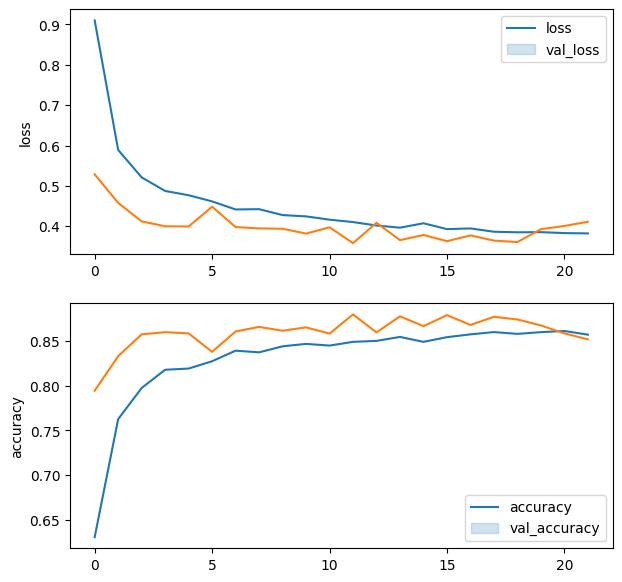

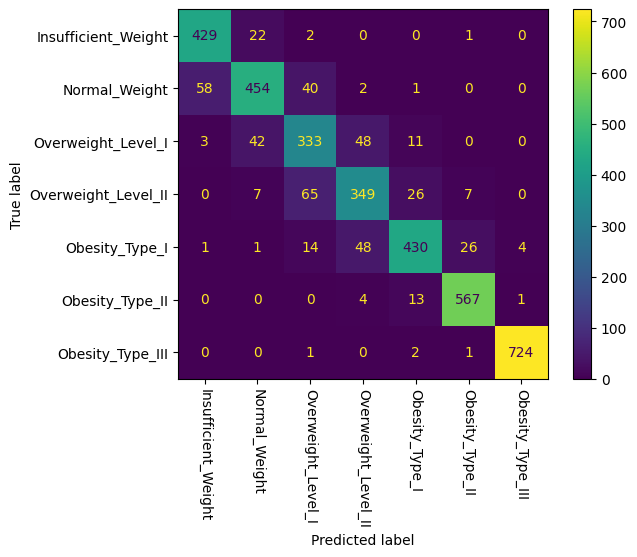

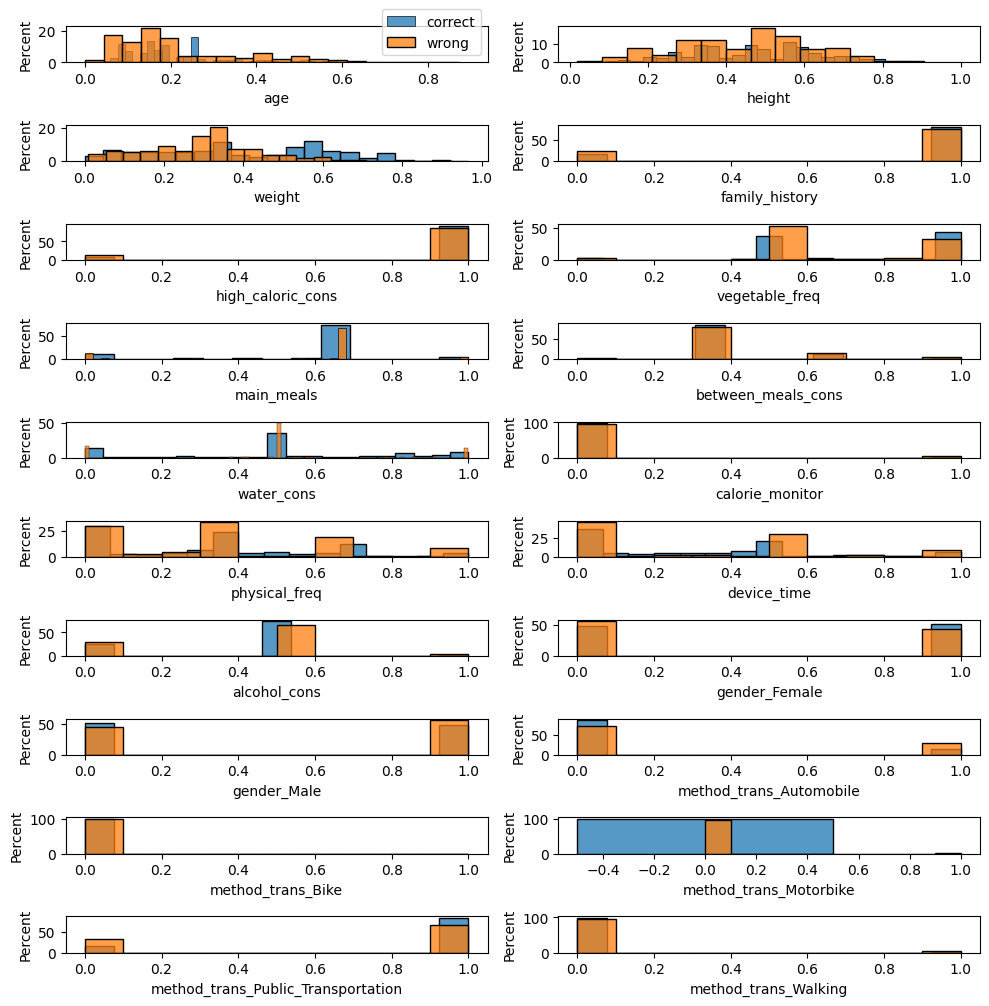

In [123]:
test_clf_model(model_bigger, callbacks, X_train, X_valid, y_train, y_valid)

More or less the same

## Less features?

In [124]:
X_train.columns

Index(['age', 'height', 'weight', 'family_history', 'high_caloric_cons',
       'vegetable_freq', 'main_meals', 'between_meals_cons', 'water_cons',
       'calorie_monitor', 'physical_freq', 'device_time', 'alcohol_cons',
       'gender_Female', 'gender_Male', 'method_trans_Automobile',
       'method_trans_Bike', 'method_trans_Motorbike',
       'method_trans_Public_Transportation', 'method_trans_Walking'],
      dtype='object')

In [125]:
X_train_reduced = X_train.drop([
    'age', 'height', 'calorie_monitor',
    'gender_Female', 'gender_Male', 'method_trans_Automobile',
    'method_trans_Bike', 'method_trans_Motorbike',
    'method_trans_Public_Transportation', 'method_trans_Walking'
], axis=1)

In [126]:
X_valid_reduced = X_valid.drop([
    'age', 'height', 'calorie_monitor',
    'gender_Female', 'gender_Male', 'method_trans_Automobile',
    'method_trans_Bike', 'method_trans_Motorbike',
    'method_trans_Public_Transportation', 'method_trans_Walking'
], axis=1)

In [127]:
n_features = X_train_reduced.shape[1]

In [128]:
model_bigger = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=[n_features]),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model_bigger.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

117/117 [==============================] - 0s 719us/step


C:\Users\User\AppData\Local\Temp\ipykernel_9040\1364407135.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


                     precision    recall  f1-score   support

Insufficient_Weight       0.79      0.91      0.85       454
      Normal_Weight       0.70      0.65      0.67       555
 Overweight_Level_I       0.60      0.65      0.63       437
Overweight_Level_II       0.64      0.65      0.65       454
     Obesity_Type_I       0.80      0.65      0.72       524
    Obesity_Type_II       0.94      0.94      0.94       585
   Obesity_Type_III       0.98      0.99      0.98       728

           accuracy                           0.80      3737
          macro avg       0.78      0.78      0.78      3737
       weighted avg       0.80      0.80      0.79      3737

wrong shape: (765, 20)
right shape: (2972, 20)


C:\Users\User\AppData\Local\Temp\ipykernel_9040\1364407135.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


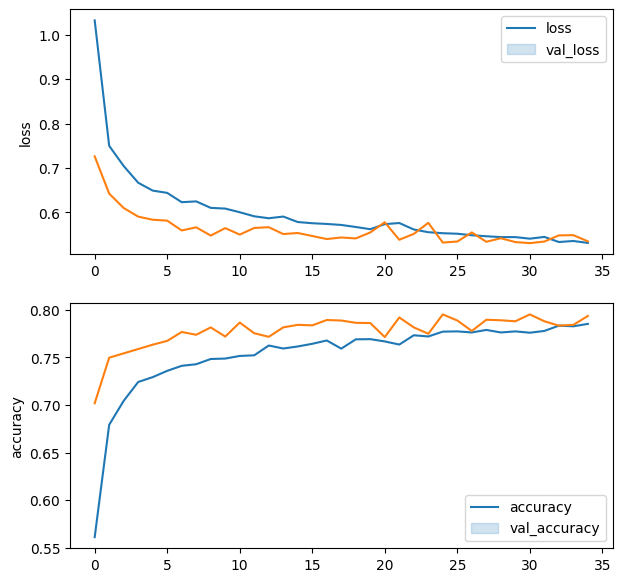

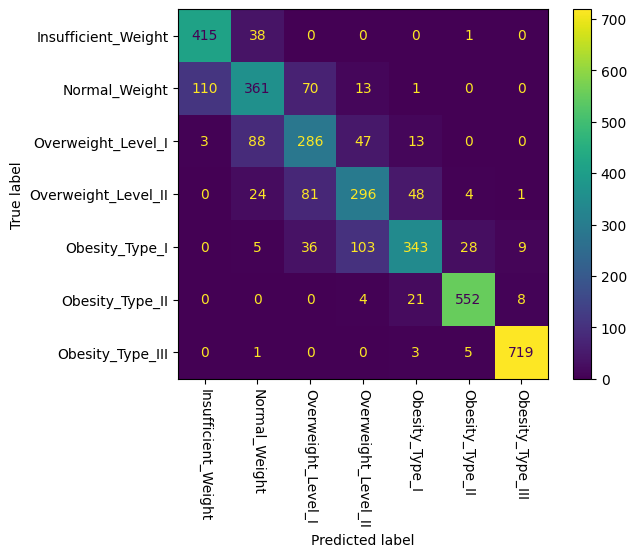

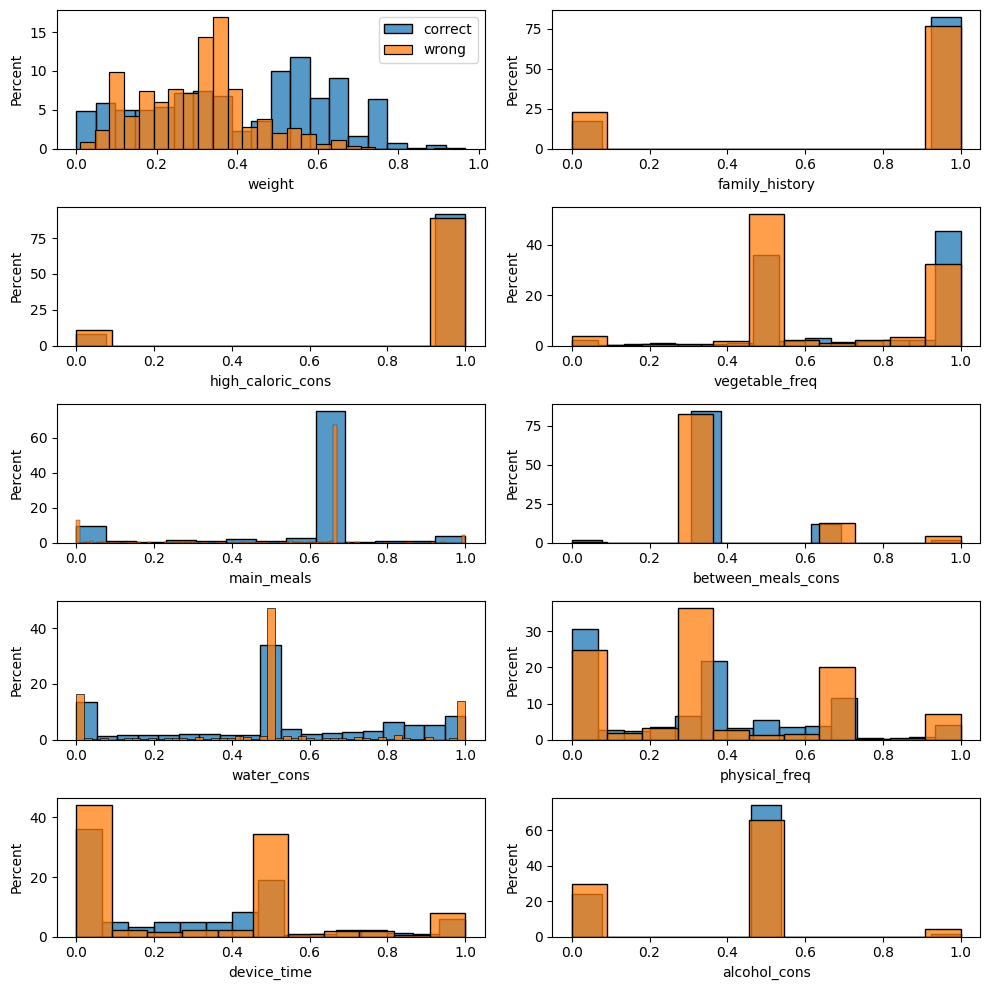

In [129]:
test_clf_model(model_bigger, callbacks, X_train_reduced, X_valid_reduced, y_train, y_valid)

Worse, unfortunately - we might have gone too far.

## bringing back age and weight
Even though it was hard to determine the relation between these factors and the obesity classes visually, they still could have provided valuable information to the models, as seen in the results

In [130]:
X_train_reduced = X_train.drop([
    'calorie_monitor',
    'gender_Female', 'gender_Male', 'method_trans_Automobile',
    'method_trans_Bike', 'method_trans_Motorbike',
    'method_trans_Public_Transportation', 'method_trans_Walking'
], axis=1)
X_valid_reduced = X_valid.drop([
    'calorie_monitor',
    'gender_Female', 'gender_Male', 'method_trans_Automobile',
    'method_trans_Bike', 'method_trans_Motorbike',
    'method_trans_Public_Transportation', 'method_trans_Walking'
], axis=1)

n_features = X_train_reduced.shape[1]

In [131]:
model_bigger = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=[n_features]),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model_bigger.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

117/117 [==============================] - 0s 733us/step


C:\Users\User\AppData\Local\Temp\ipykernel_9040\1364407135.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


                     precision    recall  f1-score   support

Insufficient_Weight       0.90      0.93      0.91       454
      Normal_Weight       0.82      0.86      0.84       555
 Overweight_Level_I       0.75      0.70      0.72       437
Overweight_Level_II       0.79      0.77      0.78       454
     Obesity_Type_I       0.87      0.82      0.85       524
    Obesity_Type_II       0.91      0.96      0.93       585
   Obesity_Type_III       0.99      0.97      0.98       728

           accuracy                           0.87      3737
          macro avg       0.86      0.86      0.86      3737
       weighted avg       0.87      0.87      0.87      3737

wrong shape: (479, 22)
right shape: (3258, 22)


C:\Users\User\AppData\Local\Temp\ipykernel_9040\1364407135.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


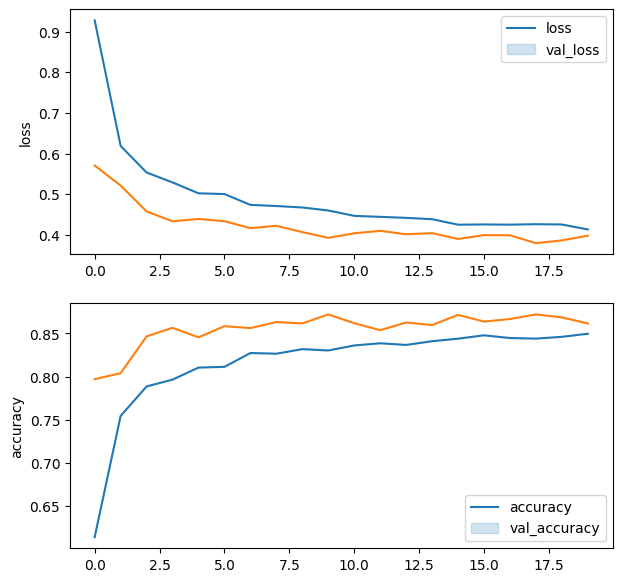

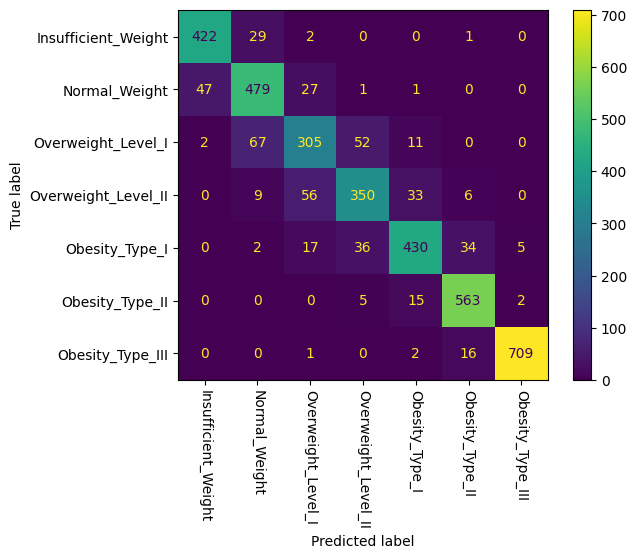

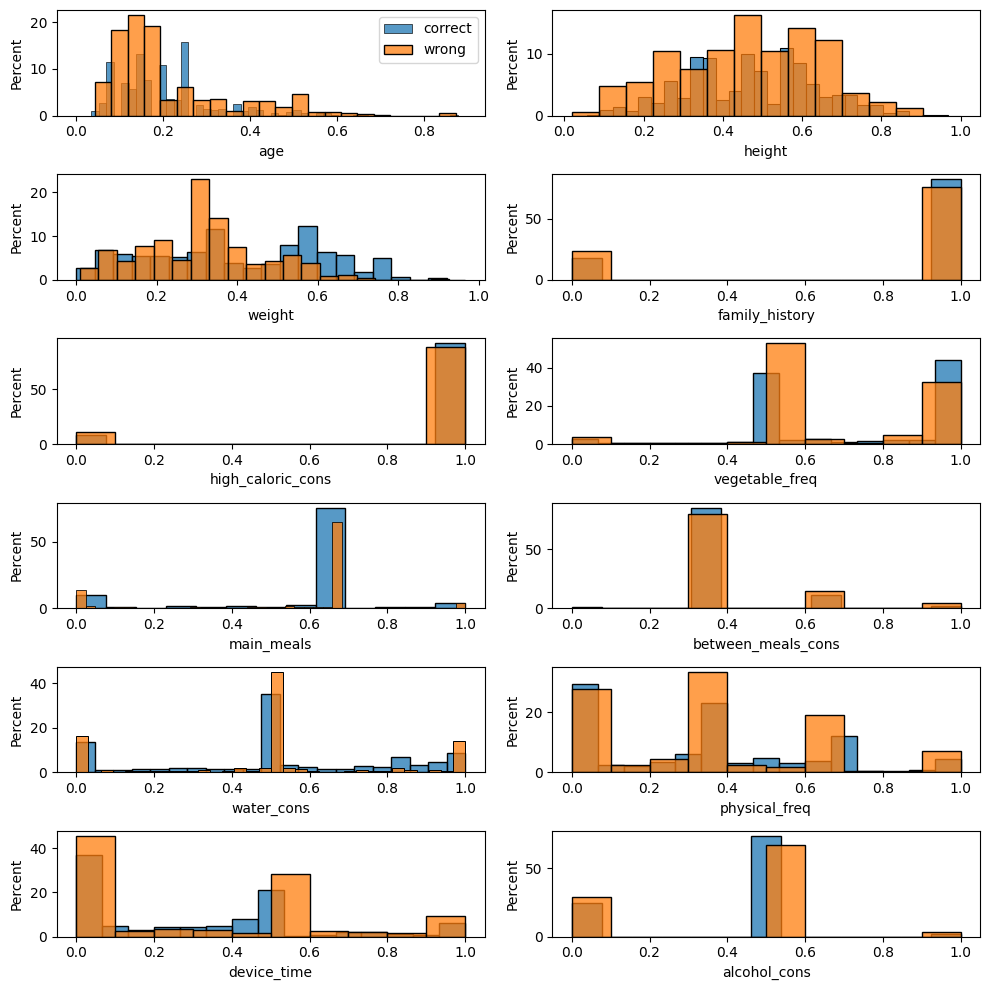

In [132]:
test_clf_model(model_bigger, callbacks, X_train_reduced, X_valid_reduced, y_train, y_valid)

### gender and calorie monitor?

In [133]:
X_train_reduced = X_train.drop([
    'method_trans_Automobile',
    'method_trans_Bike', 'method_trans_Motorbike',
    'method_trans_Public_Transportation', 'method_trans_Walking'
], axis=1)
X_valid_reduced = X_valid.drop([
    'method_trans_Automobile',
    'method_trans_Bike', 'method_trans_Motorbike',
    'method_trans_Public_Transportation', 'method_trans_Walking'
], axis=1)

n_features = X_train_reduced.shape[1]

model_bigger = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=[n_features]),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model_bigger.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

117/117 [==============================] - 0s 707us/step


C:\Users\User\AppData\Local\Temp\ipykernel_9040\1364407135.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.89      0.91       454
      Normal_Weight       0.85      0.86      0.85       555
 Overweight_Level_I       0.72      0.78      0.75       437
Overweight_Level_II       0.80      0.73      0.77       454
     Obesity_Type_I       0.86      0.82      0.84       524
    Obesity_Type_II       0.91      0.97      0.94       585
   Obesity_Type_III       0.99      0.99      0.99       728

           accuracy                           0.88      3737
          macro avg       0.87      0.86      0.86      3737
       weighted avg       0.88      0.88      0.88      3737

wrong shape: (459, 25)
right shape: (3278, 25)


C:\Users\User\AppData\Local\Temp\ipykernel_9040\1364407135.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


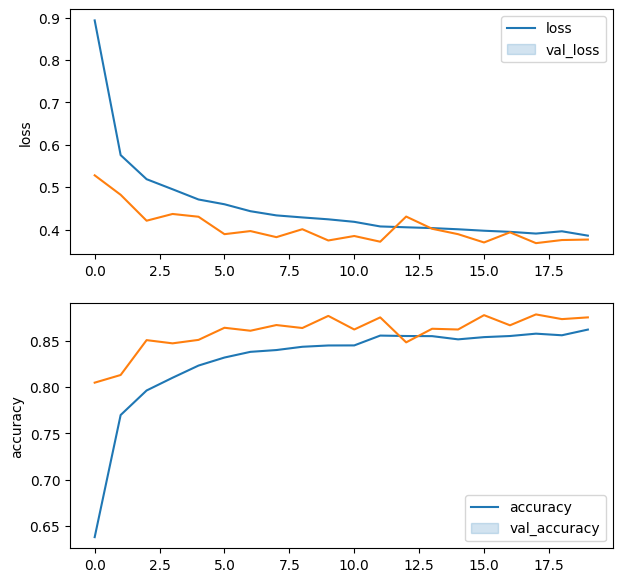

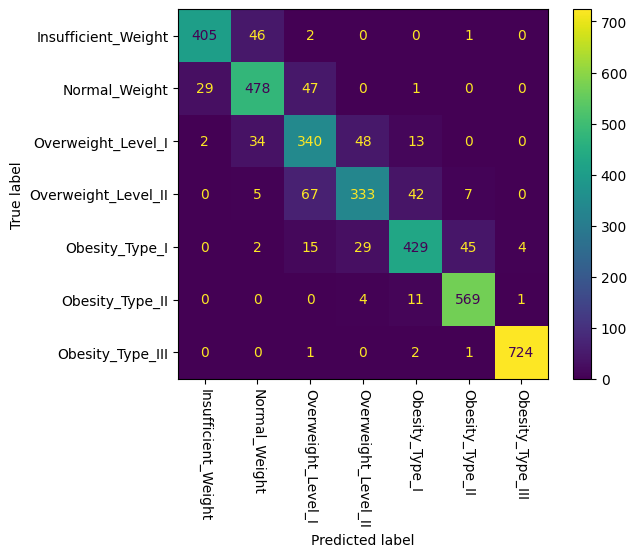

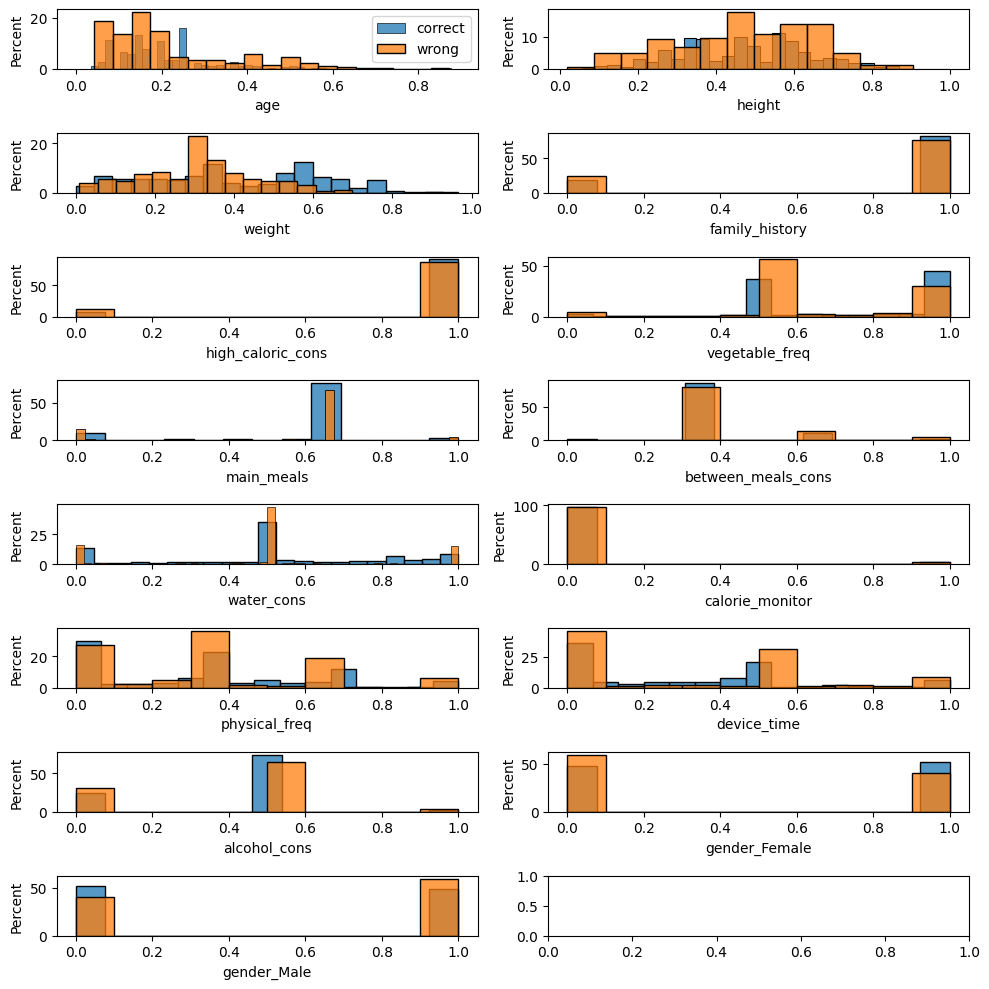

In [134]:
test_clf_model(model_bigger, callbacks, X_train_reduced, X_valid_reduced, y_train, y_valid)

## BatchNormalization

In [135]:
model_bigger_batchnorm = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=[n_features]),
    tf.keras.layers.Dropout(0.3),
    layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    layers.BatchNormalization(),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model_bigger_batchnorm.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

 65/117 [===============>..............] - ETA: 0s

C:\Users\User\AppData\Local\Temp\ipykernel_9040\1364407135.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


117/117 [==============================] - 0s 801us/step
                     precision    recall  f1-score   support

Insufficient_Weight       0.89      0.93      0.91       454
      Normal_Weight       0.87      0.81      0.84       555
 Overweight_Level_I       0.74      0.71      0.72       437
Overweight_Level_II       0.73      0.81      0.77       454
     Obesity_Type_I       0.87      0.83      0.85       524
    Obesity_Type_II       0.94      0.96      0.95       585
   Obesity_Type_III       0.99      0.99      0.99       728

           accuracy                           0.87      3737
          macro avg       0.86      0.86      0.86      3737
       weighted avg       0.88      0.87      0.87      3737

wrong shape: (469, 25)
right shape: (3268, 25)


C:\Users\User\AppData\Local\Temp\ipykernel_9040\1364407135.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


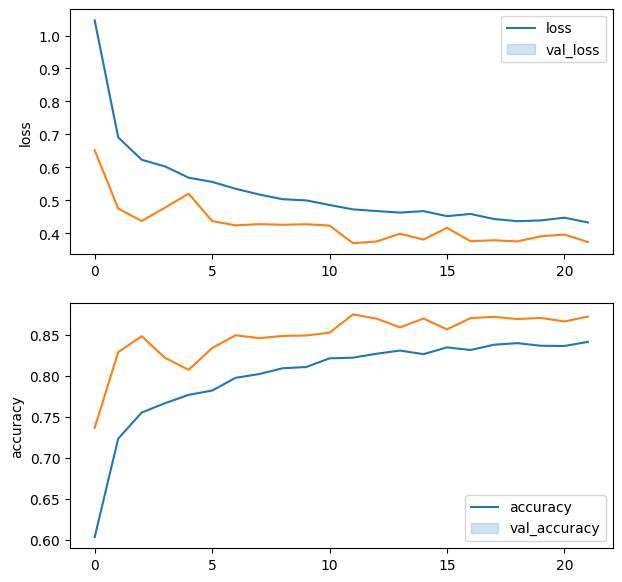

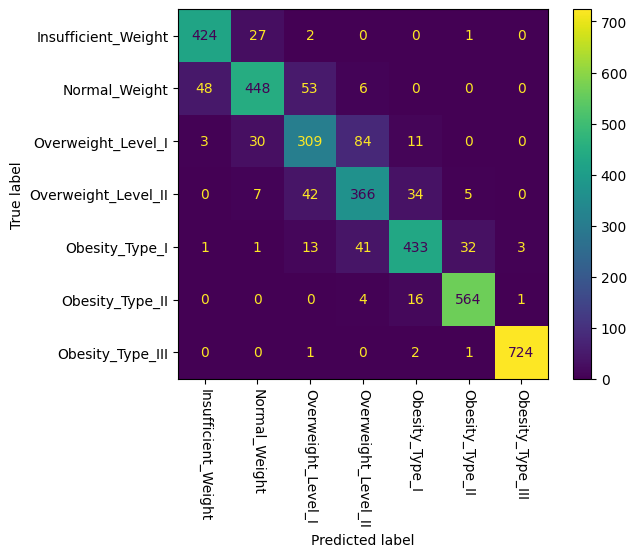

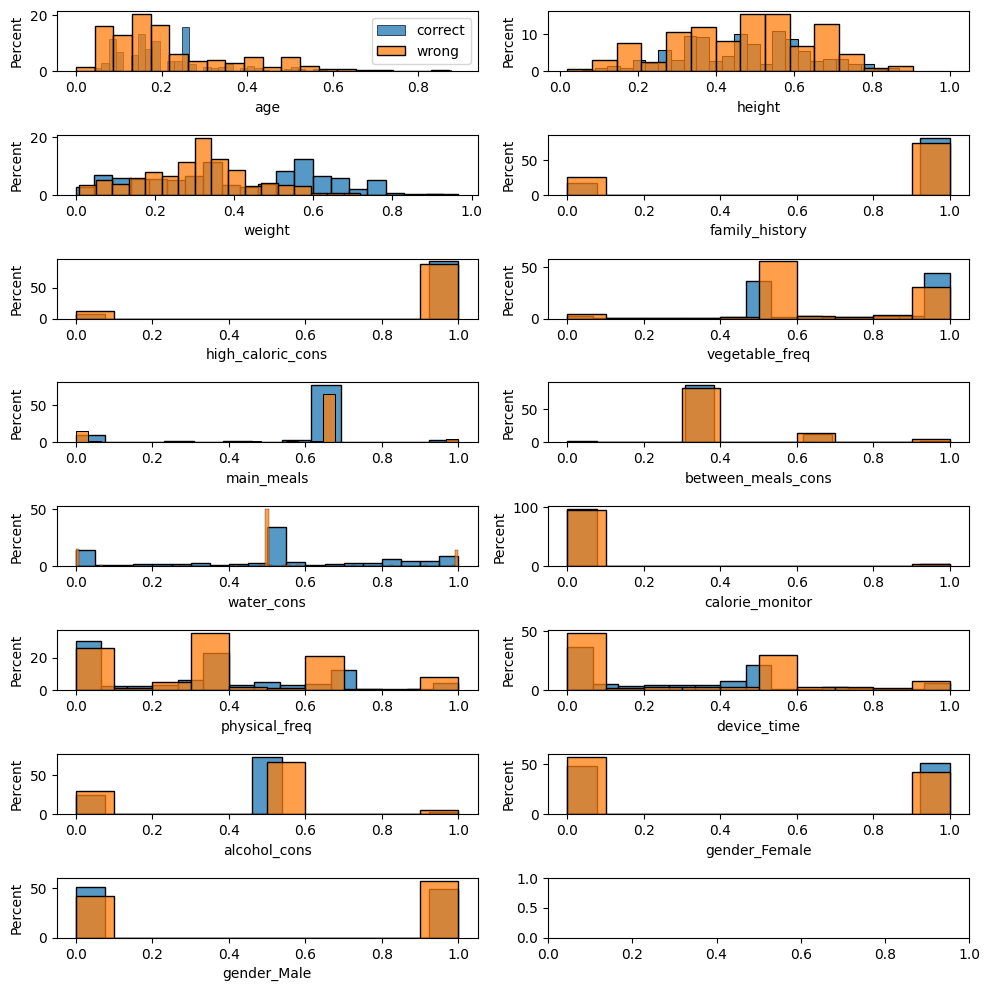

In [136]:
test_clf_model(model_bigger_batchnorm, callbacks, X_train_reduced, X_valid_reduced, y_train, y_valid)

## Different optimizers
* SGD
* Adagrad

In [137]:
model_bigger_batchnorm = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=[n_features]),
    tf.keras.layers.Dropout(0.3),
    layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    layers.BatchNormalization(),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model_bigger_batchnorm.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

 63/117 [===============>..............] - ETA: 0s

C:\Users\User\AppData\Local\Temp\ipykernel_9040\1364407135.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


117/117 [==============================] - 0s 795us/step
                     precision    recall  f1-score   support

Insufficient_Weight       0.87      0.96      0.91       454
      Normal_Weight       0.85      0.82      0.83       555
 Overweight_Level_I       0.73      0.69      0.71       437
Overweight_Level_II       0.73      0.75      0.74       454
     Obesity_Type_I       0.87      0.81      0.84       524
    Obesity_Type_II       0.93      0.96      0.95       585
   Obesity_Type_III       0.99      1.00      0.99       728

           accuracy                           0.87      3737
          macro avg       0.85      0.85      0.85      3737
       weighted avg       0.87      0.87      0.87      3737

wrong shape: (496, 25)
right shape: (3241, 25)


C:\Users\User\AppData\Local\Temp\ipykernel_9040\1364407135.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


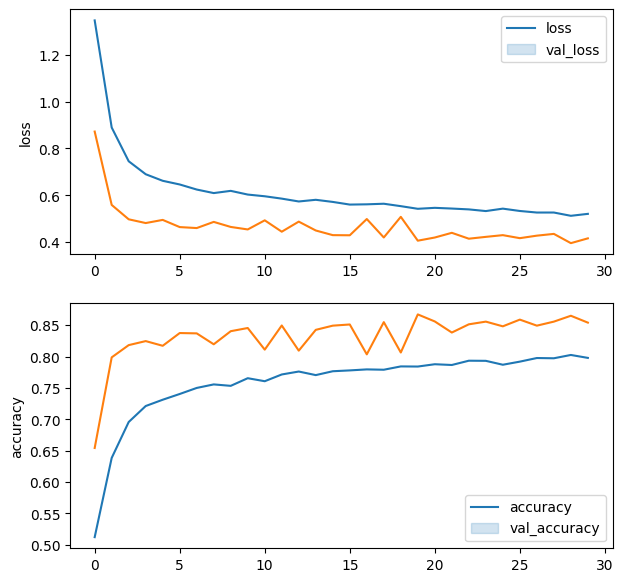

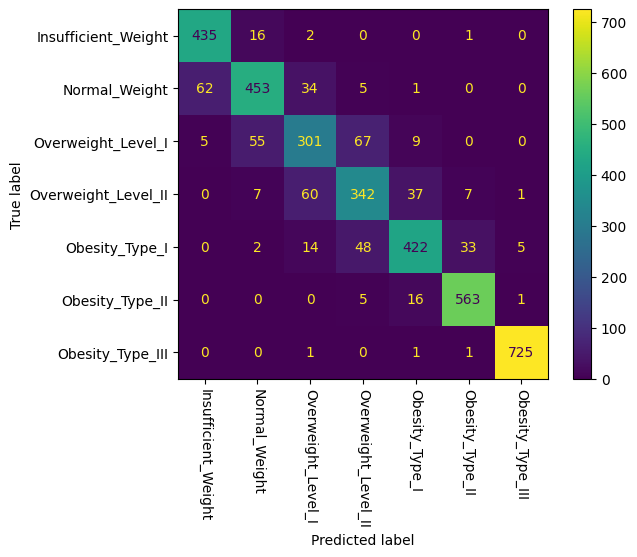

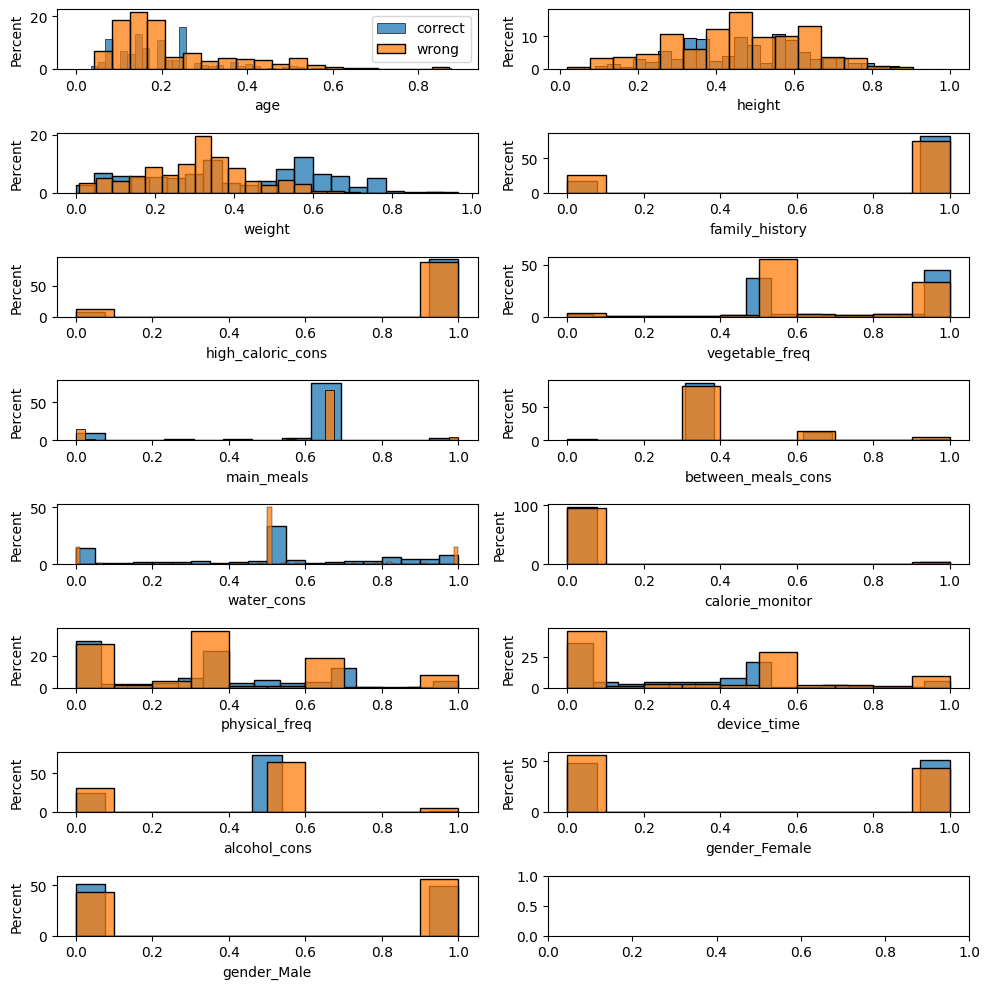

In [138]:
test_clf_model(model_bigger_batchnorm, callbacks, X_train_reduced, X_valid_reduced, y_train, y_valid)

In [139]:
model_bigger_batchnorm_ada = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=[n_features]),
    tf.keras.layers.Dropout(0.3),
    layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    layers.BatchNormalization(),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model_bigger_batchnorm_ada.compile(optimizer='Adagrad',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

 66/117 [===============>..............] - ETA: 0s

C:\Users\User\AppData\Local\Temp\ipykernel_9040\1364407135.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


117/117 [==============================] - 0s 775us/step
                     precision    recall  f1-score   support

Insufficient_Weight       0.81      0.85      0.83       454
      Normal_Weight       0.66      0.75      0.70       555
 Overweight_Level_I       0.66      0.41      0.51       437
Overweight_Level_II       0.62      0.66      0.64       454
     Obesity_Type_I       0.74      0.66      0.69       524
    Obesity_Type_II       0.85      0.97      0.91       585
   Obesity_Type_III       0.98      1.00      0.99       728

           accuracy                           0.78      3737
          macro avg       0.76      0.76      0.75      3737
       weighted avg       0.78      0.78      0.77      3737

wrong shape: (819, 25)
right shape: (2918, 25)


C:\Users\User\AppData\Local\Temp\ipykernel_9040\1364407135.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


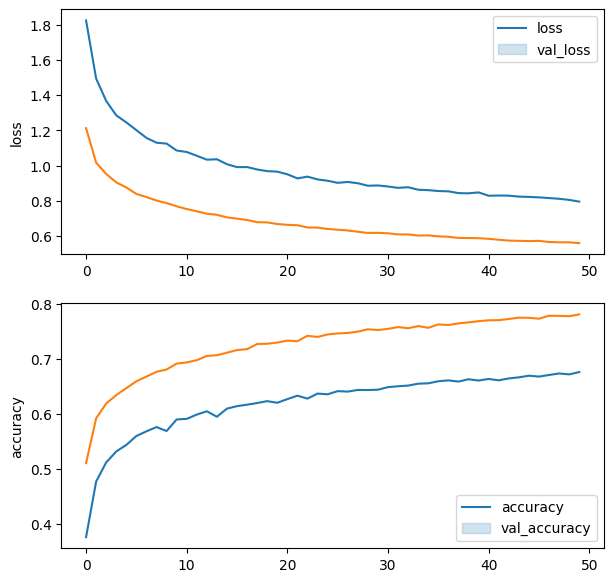

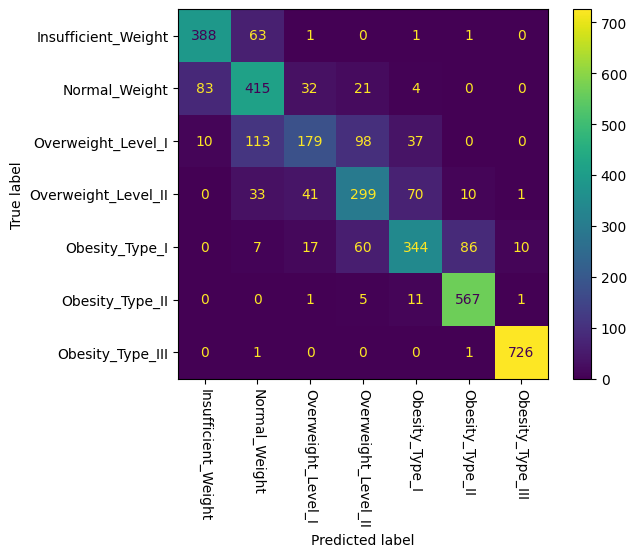

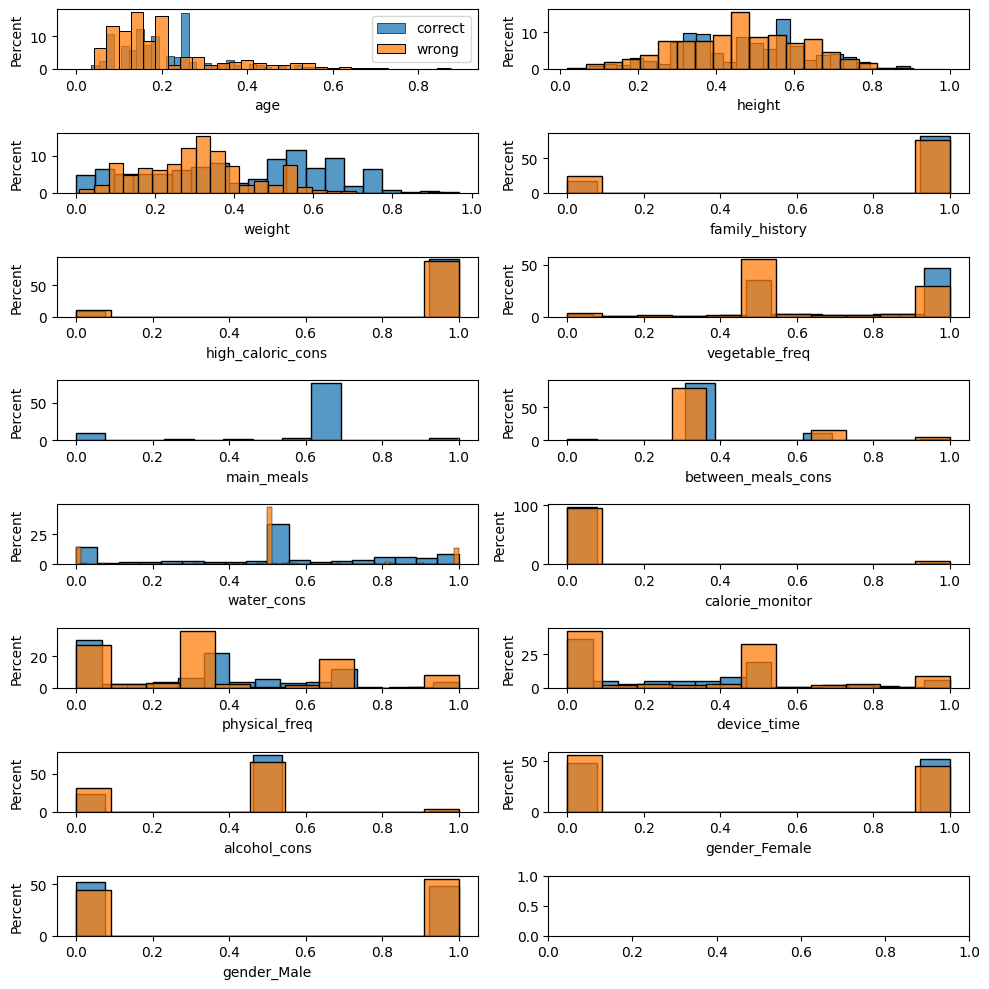

In [140]:
test_clf_model(model_bigger_batchnorm_ada, callbacks, X_train_reduced, X_valid_reduced, y_train, y_valid)

### Adagrad - more epochs and a higher batch size and a more lenient earlystopping callback

In [147]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.001,
    restore_best_weights = True,
    patience = 10
)

callbacks = [early_stop]

In [148]:
model_bigger_batchnorm_ada = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=[n_features]),
    tf.keras.layers.Dropout(0.3),
    layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    layers.BatchNormalization(),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model_bigger_batchnorm_ada.compile(optimizer='Adagrad',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

 61/117 [==============>...............] - ETA: 0s

C:\Users\User\AppData\Local\Temp\ipykernel_9040\466424860.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


117/117 [==============================] - 0s 836us/step
                     precision    recall  f1-score   support

Insufficient_Weight       0.88      0.91      0.89       454
      Normal_Weight       0.83      0.79      0.81       555
 Overweight_Level_I       0.72      0.66      0.68       437
Overweight_Level_II       0.67      0.77      0.72       454
     Obesity_Type_I       0.84      0.77      0.80       524
    Obesity_Type_II       0.92      0.96      0.94       585
   Obesity_Type_III       0.99      0.99      0.99       728

           accuracy                           0.85      3737
          macro avg       0.84      0.83      0.83      3737
       weighted avg       0.85      0.85      0.85      3737

wrong shape: (563, 25)
right shape: (3174, 25)


C:\Users\User\AppData\Local\Temp\ipykernel_9040\466424860.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


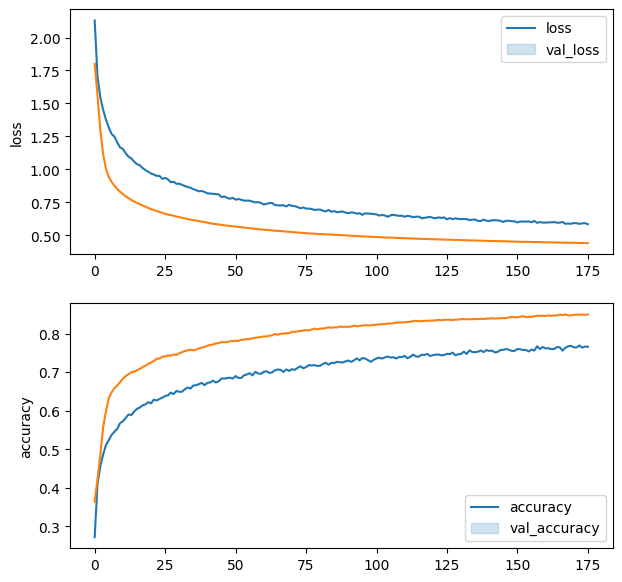

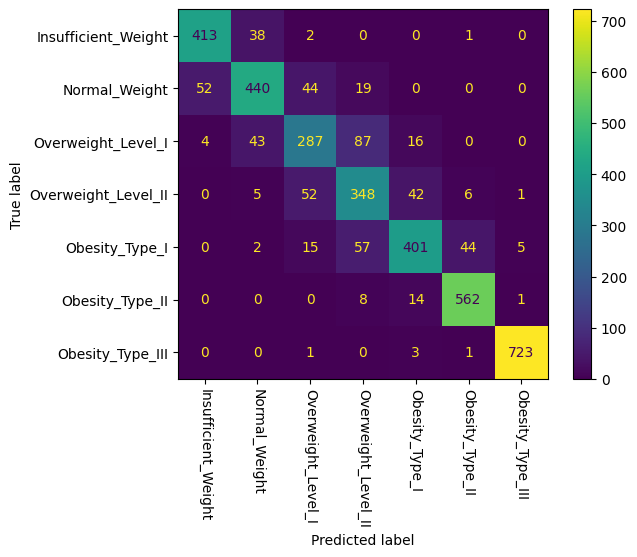

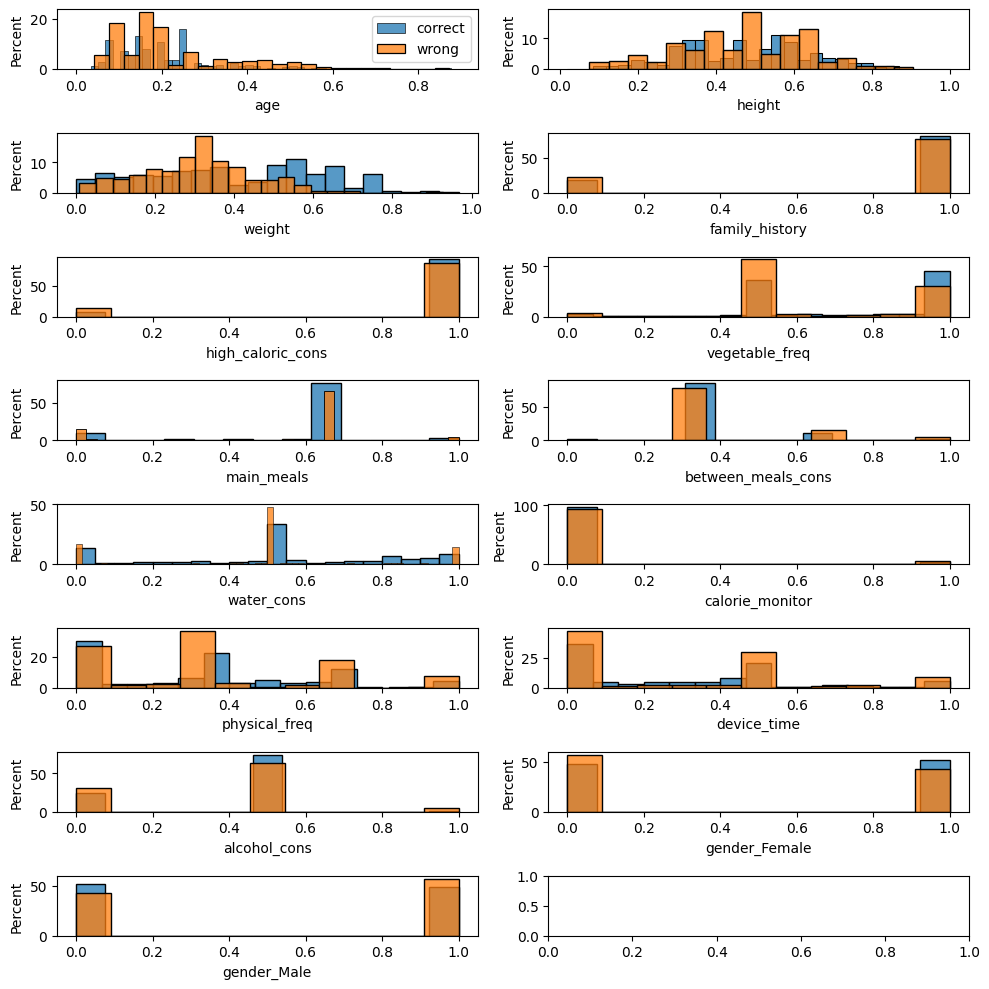

In [149]:
test_clf_model(model_bigger_batchnorm_ada, callbacks, X_train_reduced, X_valid_reduced, y_train, y_valid, epochs=200, batch_size=128)

Unfortunately, still lower than our initial model withotu regularizations and feature selection

### Initial smaller model with higher batch size and more epochs allowed

117/117 [==============================] - 0s 621us/step


C:\Users\User\AppData\Local\Temp\ipykernel_9040\466424860.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


                     precision    recall  f1-score   support

Insufficient_Weight       0.92      0.93      0.93       454
      Normal_Weight       0.86      0.85      0.86       555
 Overweight_Level_I       0.75      0.73      0.74       437
Overweight_Level_II       0.77      0.75      0.76       454
     Obesity_Type_I       0.84      0.85      0.85       524
    Obesity_Type_II       0.94      0.96      0.95       585
   Obesity_Type_III       0.99      0.99      0.99       728

           accuracy                           0.88      3737
          macro avg       0.87      0.87      0.87      3737
       weighted avg       0.88      0.88      0.88      3737

wrong shape: (452, 25)
right shape: (3285, 25)


C:\Users\User\AppData\Local\Temp\ipykernel_9040\466424860.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


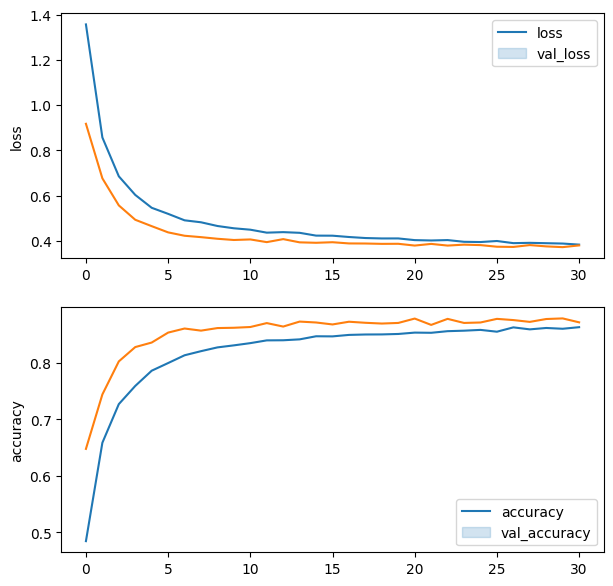

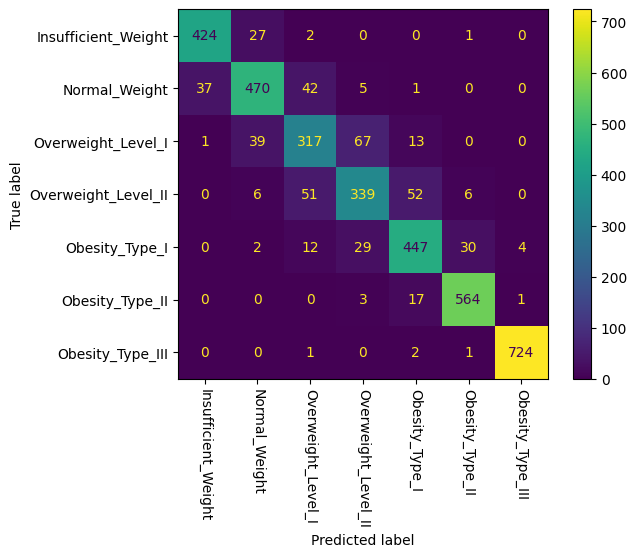

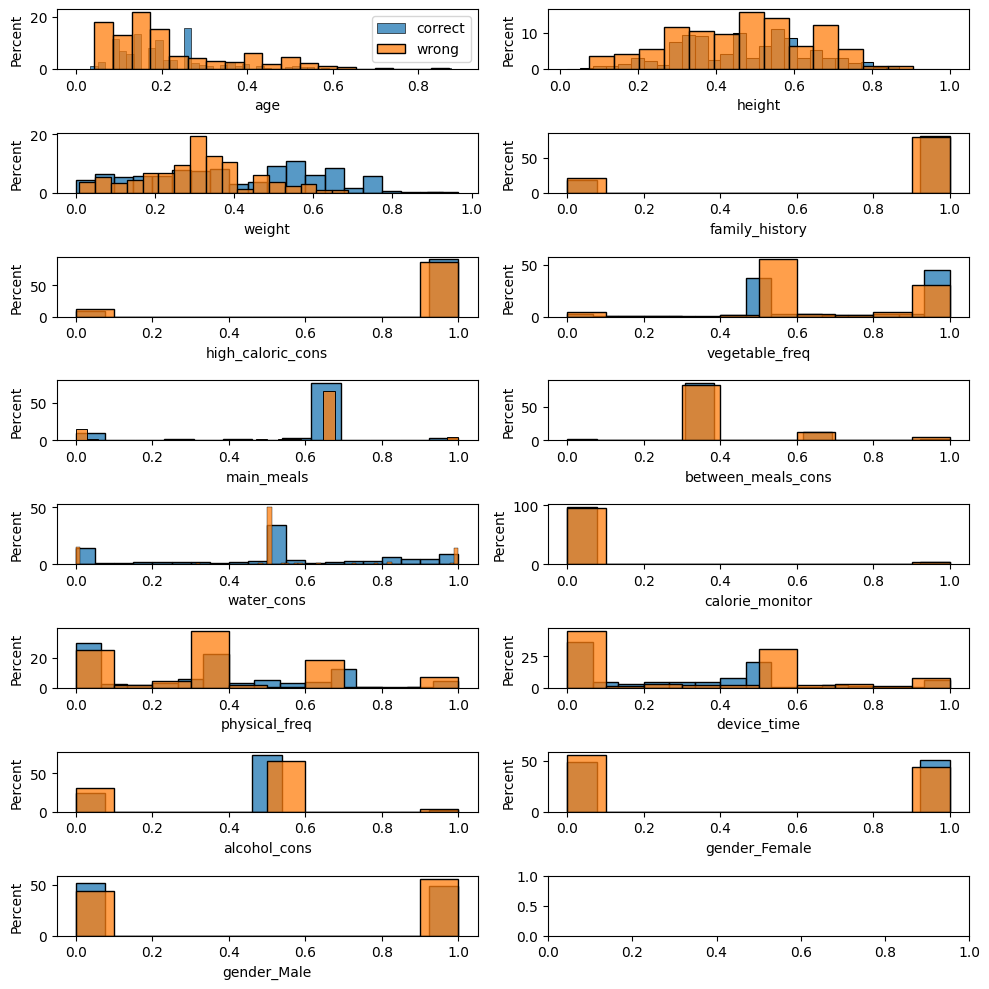

In [151]:
model_smaller = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=[n_features]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model_smaller.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

test_clf_model(model_smaller, callbacks, X_train_reduced, X_valid_reduced, y_train, y_valid, epochs=200, batch_size=128)

Indeed we are back to a performance similar to our initial model, still its accuray does leave a lot to desire with the validation curves oscillating visibly - perhaps increasign the batch size further will help minimize that and guide the training to generalize better, comprehend the differences between classes better, by making sure it sees more sample of each class at each training step

### Smaller model, higher batch size?

117/117 [==============================] - 0s 617us/step


C:\Users\User\AppData\Local\Temp\ipykernel_9040\466424860.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


                     precision    recall  f1-score   support

Insufficient_Weight       0.91      0.92      0.92       454
      Normal_Weight       0.86      0.84      0.85       555
 Overweight_Level_I       0.74      0.77      0.75       437
Overweight_Level_II       0.80      0.73      0.76       454
     Obesity_Type_I       0.84      0.87      0.86       524
    Obesity_Type_II       0.95      0.96      0.96       585
   Obesity_Type_III       0.99      0.99      0.99       728

           accuracy                           0.88      3737
          macro avg       0.87      0.87      0.87      3737
       weighted avg       0.88      0.88      0.88      3737

wrong shape: (439, 25)
right shape: (3298, 25)


C:\Users\User\AppData\Local\Temp\ipykernel_9040\466424860.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


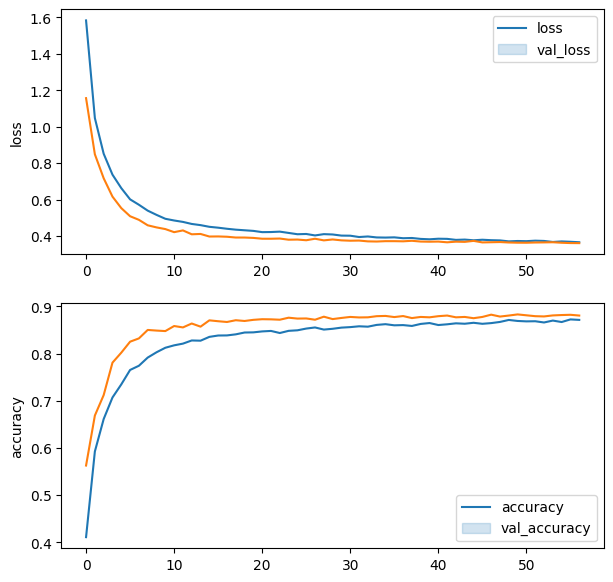

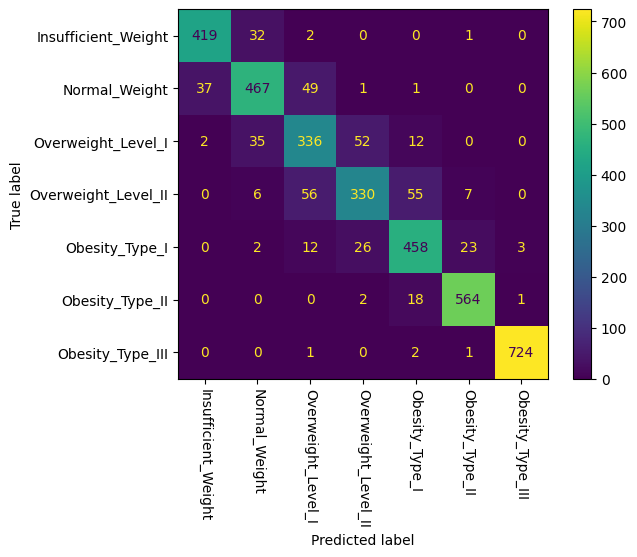

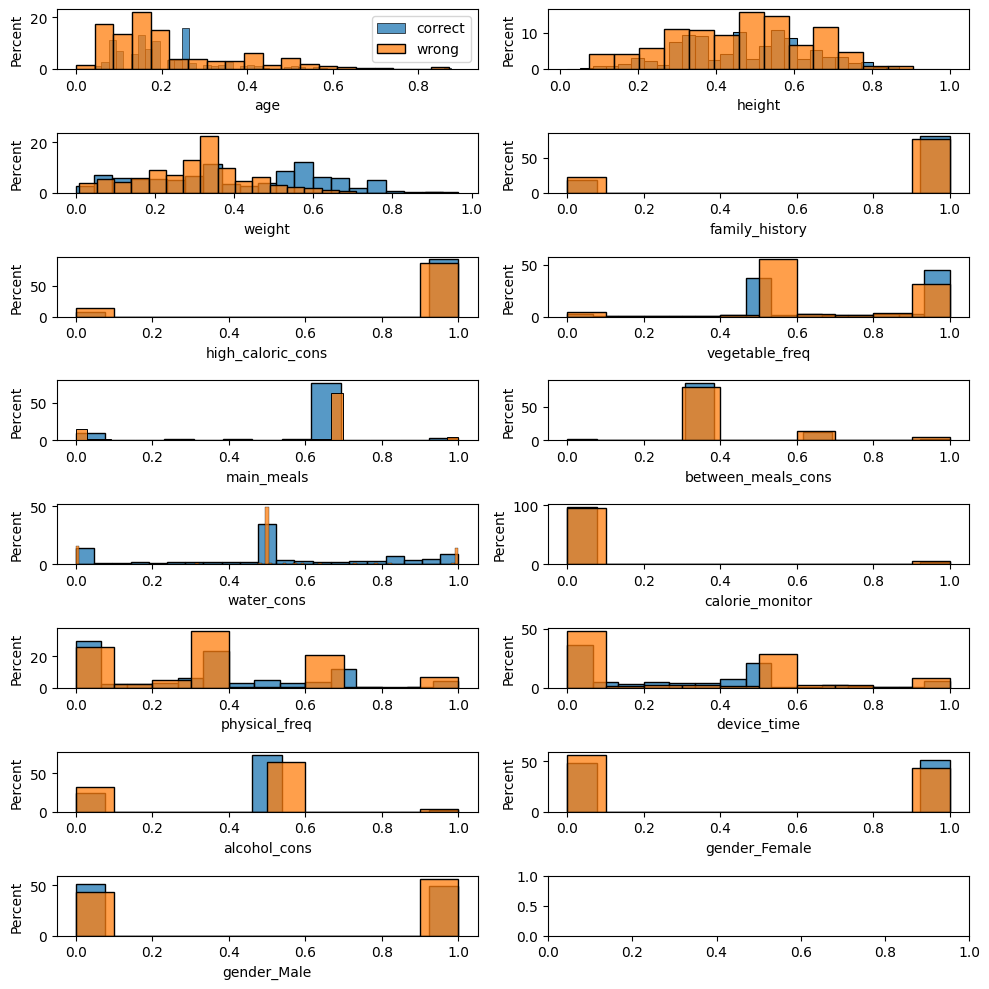

In [152]:
model_smaller = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=[n_features]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model_smaller.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

test_clf_model(model_smaller, callbacks, X_train_reduced, X_valid_reduced, y_train, y_valid, epochs=200, batch_size=256)

Indeed a small increase - let's go further?

117/117 [==============================] - 0s 612us/step


C:\Users\User\AppData\Local\Temp\ipykernel_9040\466424860.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


                     precision    recall  f1-score   support

Insufficient_Weight       0.89      0.95      0.92       454
      Normal_Weight       0.88      0.81      0.85       555
 Overweight_Level_I       0.74      0.75      0.74       437
Overweight_Level_II       0.75      0.76      0.75       454
     Obesity_Type_I       0.86      0.83      0.85       524
    Obesity_Type_II       0.94      0.97      0.95       585
   Obesity_Type_III       0.99      0.99      0.99       728

           accuracy                           0.88      3737
          macro avg       0.86      0.87      0.86      3737
       weighted avg       0.88      0.88      0.88      3737

wrong shape: (459, 25)
right shape: (3278, 25)


C:\Users\User\AppData\Local\Temp\ipykernel_9040\466424860.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


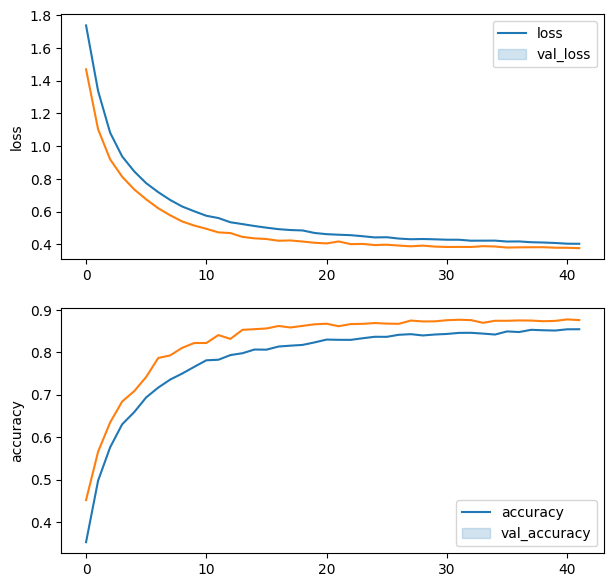

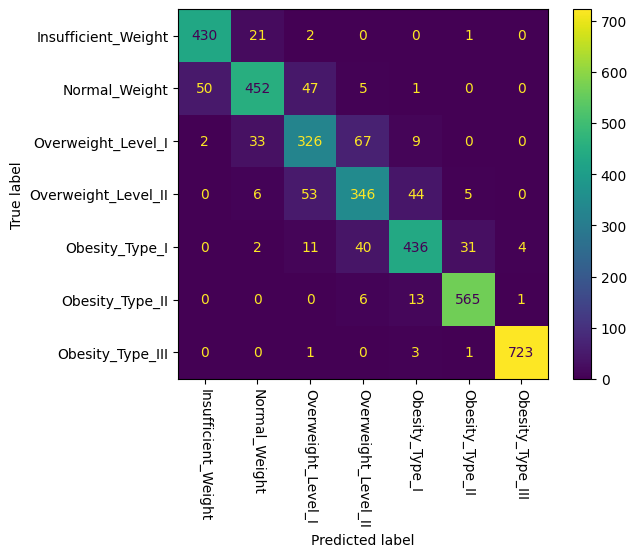

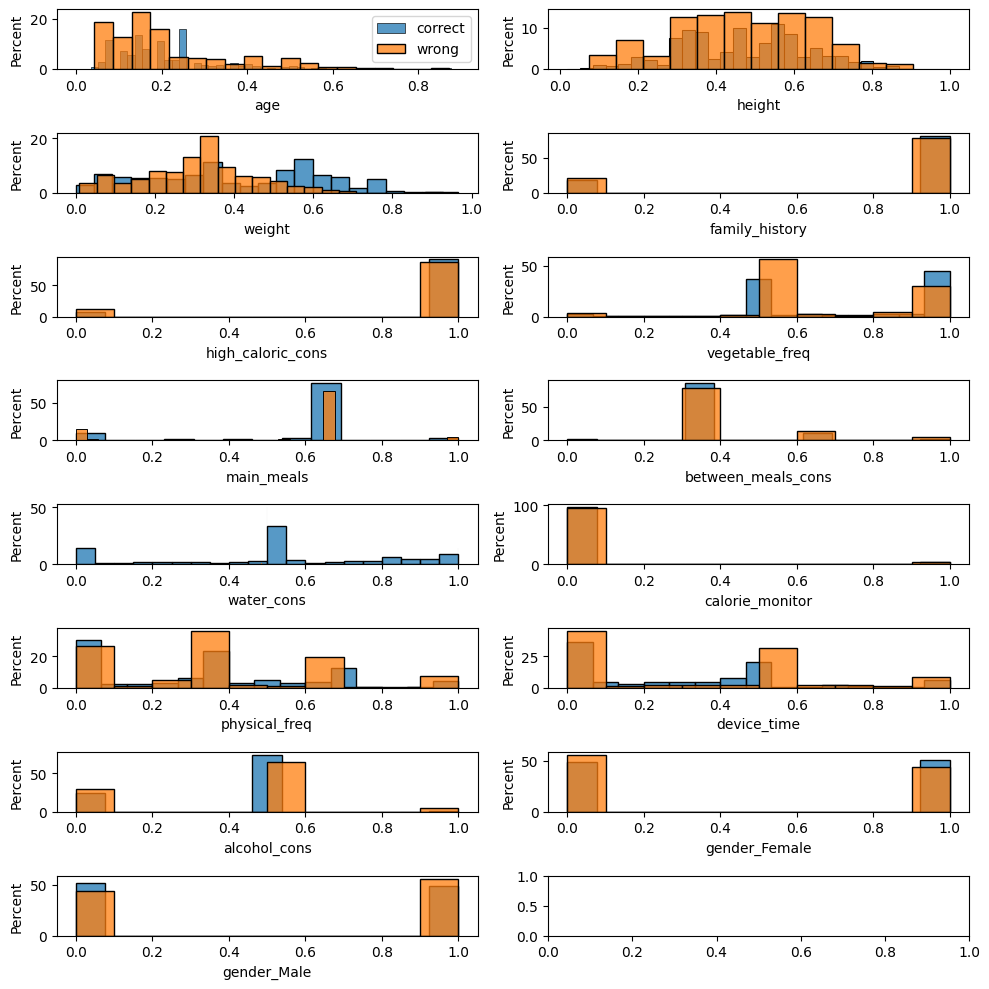

In [153]:
model_smaller = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=[n_features]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model_smaller.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

test_clf_model(model_smaller, callbacks, X_train_reduced, X_valid_reduced, y_train, y_valid, epochs=200, batch_size=512)

No further incrase

### A lower learning rate? Or higher perhaps?

Higher

117/117 [==============================] - 0s 712us/step


C:\Users\User\AppData\Local\Temp\ipykernel_9040\466424860.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


                     precision    recall  f1-score   support

Insufficient_Weight       0.90      0.95      0.92       454
      Normal_Weight       0.85      0.85      0.85       555
 Overweight_Level_I       0.80      0.66      0.72       437
Overweight_Level_II       0.73      0.82      0.78       454
     Obesity_Type_I       0.86      0.85      0.86       524
    Obesity_Type_II       0.95      0.96      0.96       585
   Obesity_Type_III       0.99      1.00      0.99       728

           accuracy                           0.88      3737
          macro avg       0.87      0.87      0.87      3737
       weighted avg       0.88      0.88      0.88      3737

wrong shape: (442, 25)
right shape: (3295, 25)


C:\Users\User\AppData\Local\Temp\ipykernel_9040\466424860.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


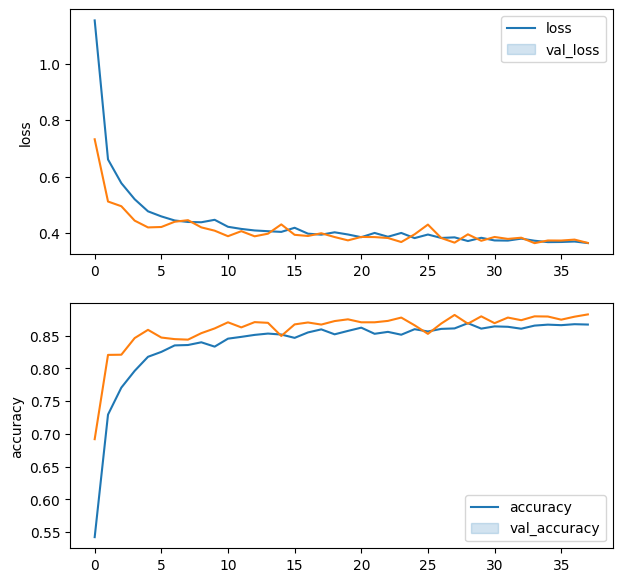

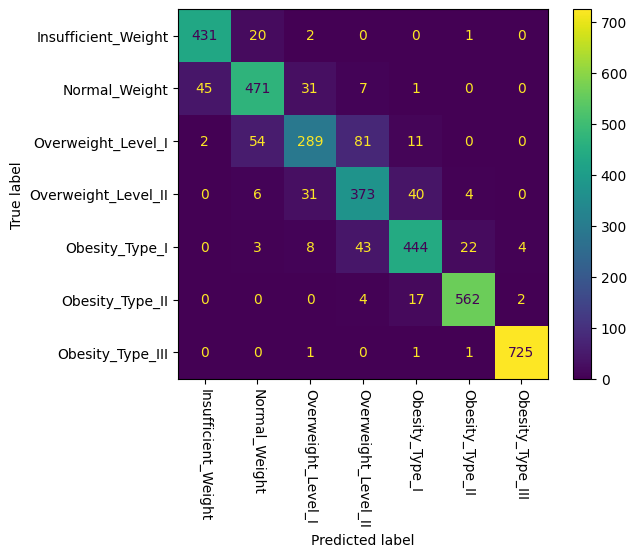

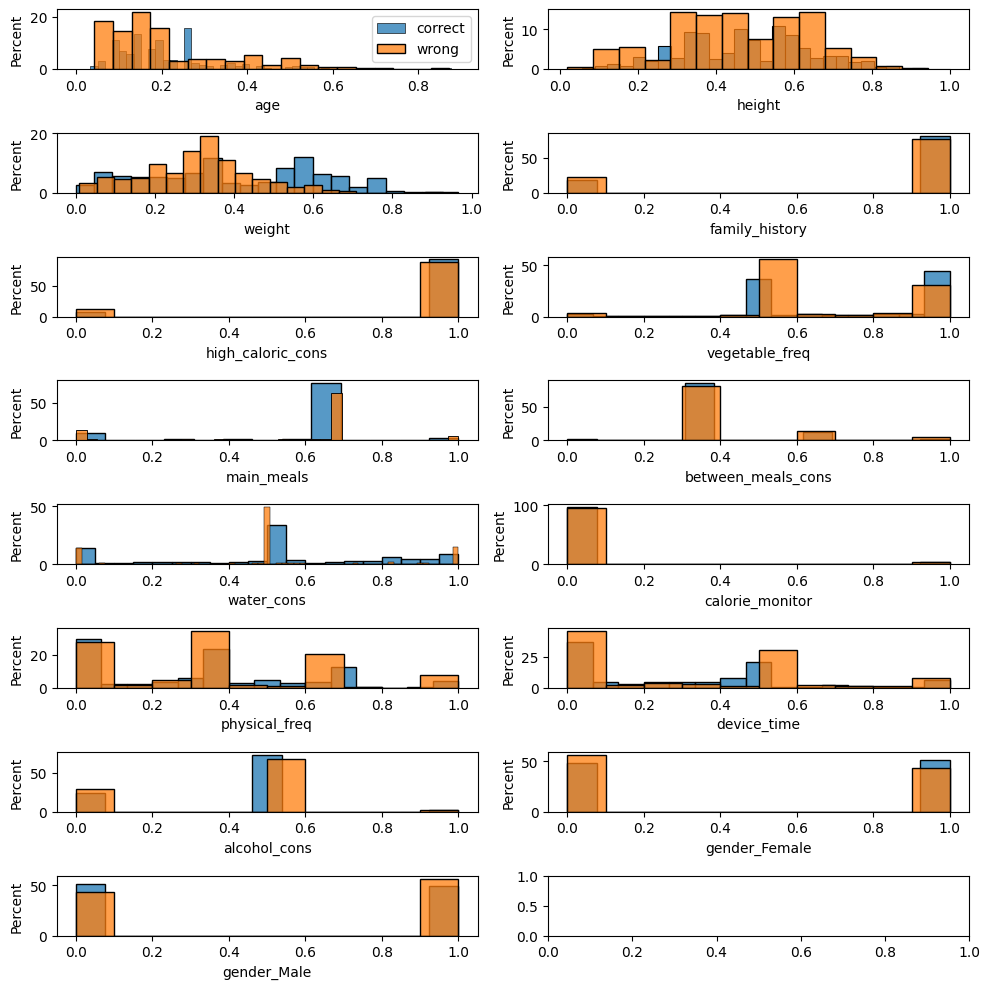

In [154]:
model_smaller = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=[n_features]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model_smaller.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

test_clf_model(model_smaller, callbacks, X_train_reduced, X_valid_reduced, y_train, y_valid, epochs=200, batch_size=512)

Lower

117/117 [==============================] - 0s 704us/step


C:\Users\User\AppData\Local\Temp\ipykernel_9040\466424860.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


                     precision    recall  f1-score   support

Insufficient_Weight       0.89      0.93      0.91       454
      Normal_Weight       0.86      0.82      0.84       555
 Overweight_Level_I       0.73      0.74      0.74       437
Overweight_Level_II       0.77      0.71      0.74       454
     Obesity_Type_I       0.83      0.84      0.84       524
    Obesity_Type_II       0.93      0.97      0.95       585
   Obesity_Type_III       0.99      0.99      0.99       728

           accuracy                           0.87      3737
          macro avg       0.86      0.86      0.86      3737
       weighted avg       0.87      0.87      0.87      3737

wrong shape: (484, 25)
right shape: (3253, 25)


C:\Users\User\AppData\Local\Temp\ipykernel_9040\466424860.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


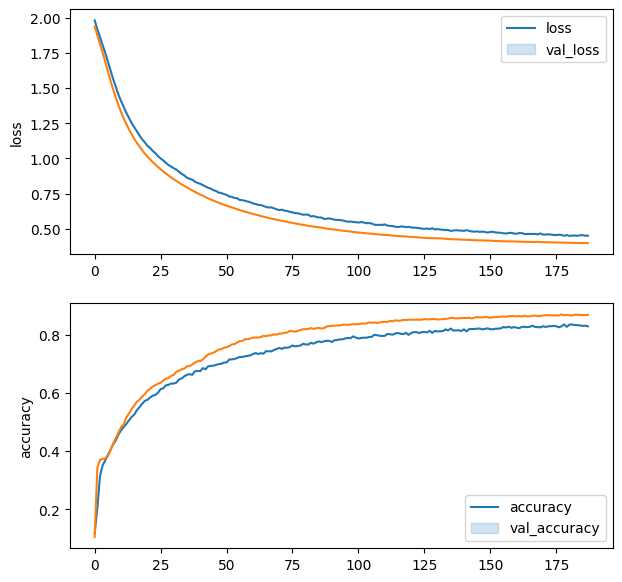

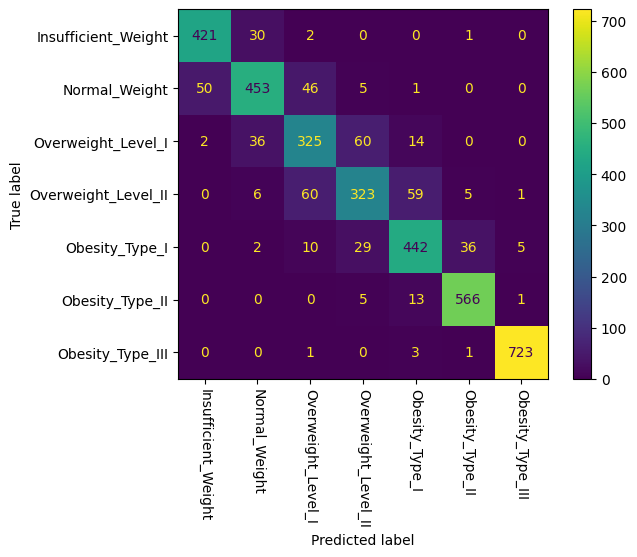

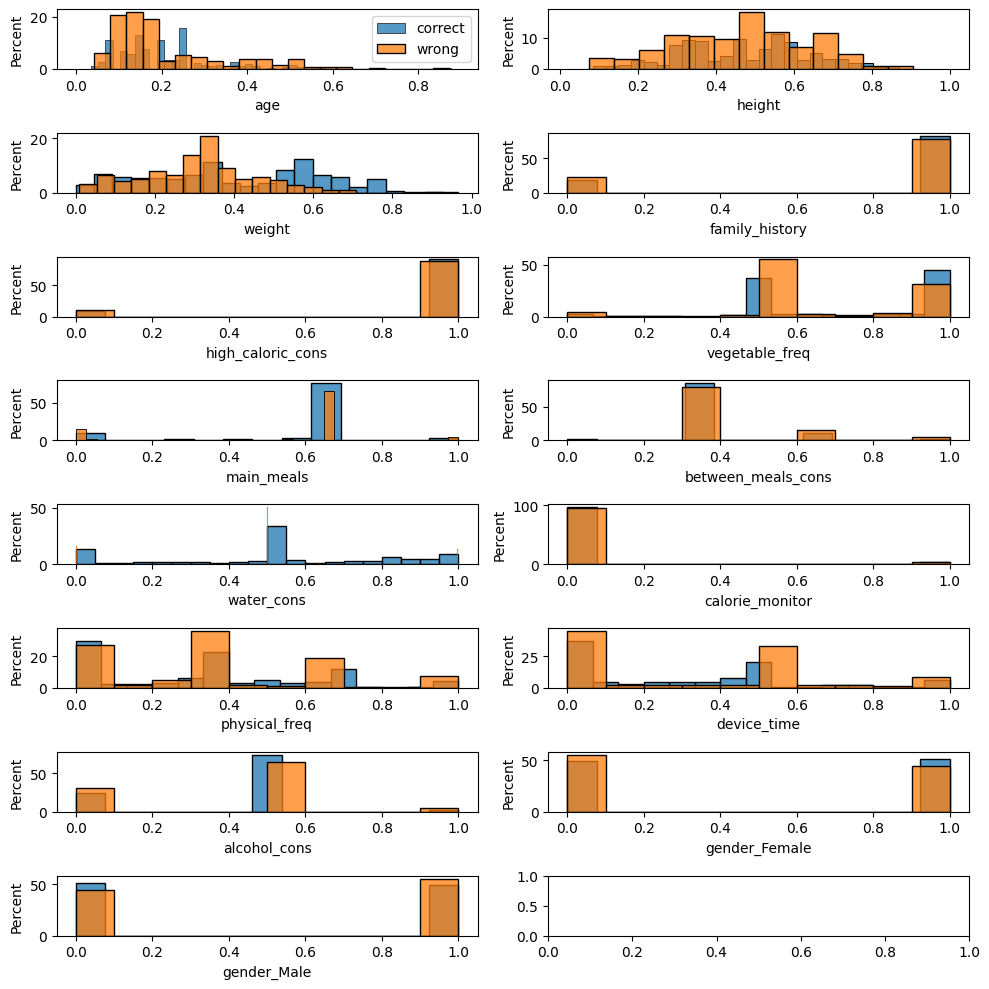

In [155]:
model_smaller = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=[n_features]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model_smaller.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

test_clf_model(model_smaller, callbacks, X_train_reduced, X_valid_reduced, y_train, y_valid, epochs=200, batch_size=512)

No improvement in any case

### Smaller model and batchnorm?

117/117 [==============================] - 0s 724us/step


C:\Users\User\AppData\Local\Temp\ipykernel_9040\466424860.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


                     precision    recall  f1-score   support

Insufficient_Weight       0.91      0.91      0.91       454
      Normal_Weight       0.81      0.82      0.82       555
 Overweight_Level_I       0.69      0.71      0.70       437
Overweight_Level_II       0.76      0.74      0.75       454
     Obesity_Type_I       0.85      0.84      0.84       524
    Obesity_Type_II       0.96      0.94      0.95       585
   Obesity_Type_III       1.00      0.99      1.00       728

           accuracy                           0.86      3737
          macro avg       0.85      0.85      0.85      3737
       weighted avg       0.87      0.86      0.87      3737

wrong shape: (505, 25)
right shape: (3232, 25)


C:\Users\User\AppData\Local\Temp\ipykernel_9040\466424860.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


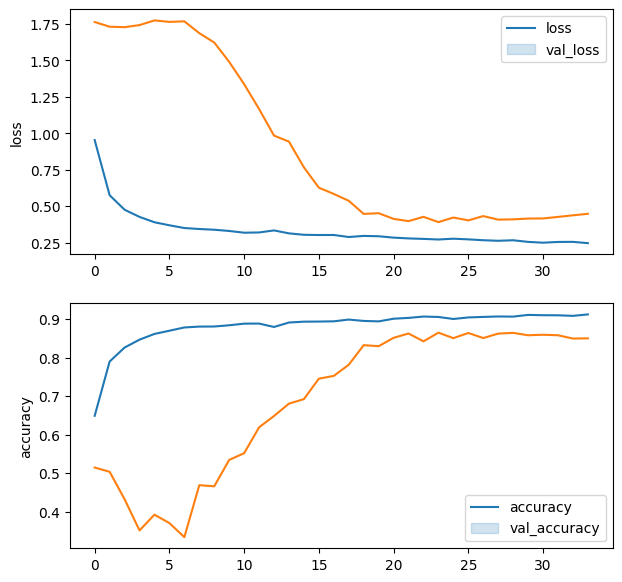

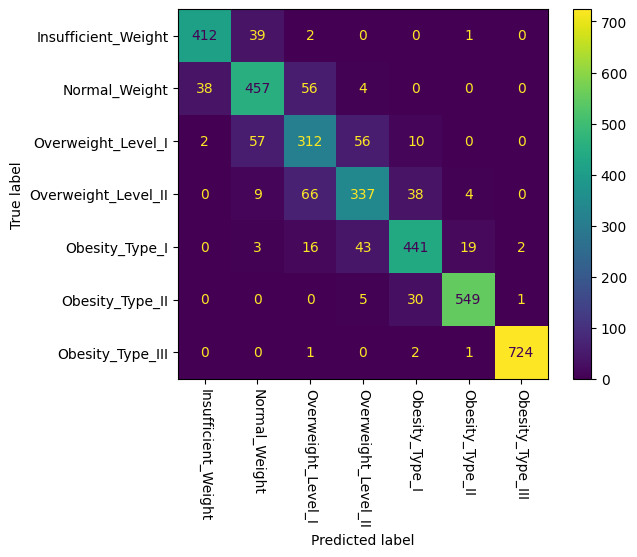

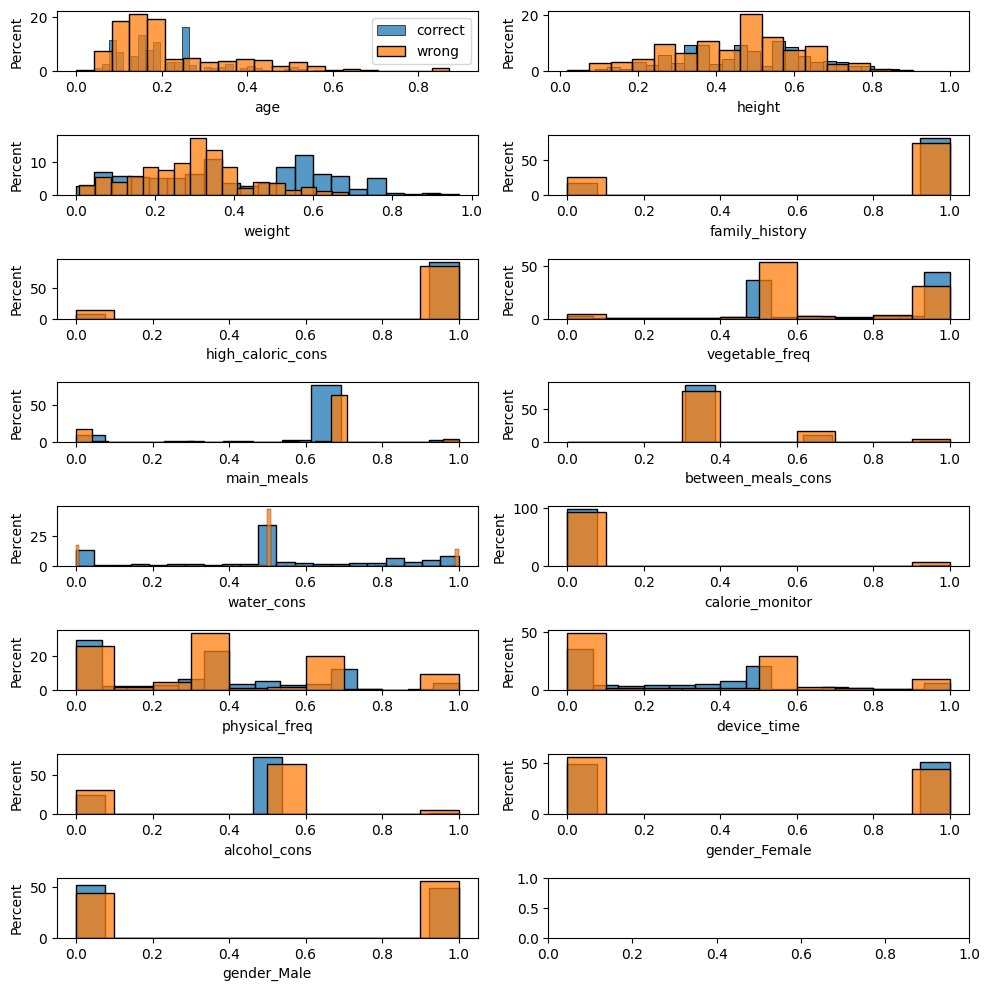

In [159]:
model_smaller = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=[n_features]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model_smaller.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

test_clf_model(model_smaller, callbacks, X_train_reduced, X_valid_reduced, y_train, y_valid, epochs=200, batch_size=512)

### Reduce learning rate on plateau?

In [164]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10,
                              min_delta = 0.001,
                              min_lr=0.00001)
callbacks_reduce = [reduce_lr]

117/117 [==============================] - 0s 672us/step


C:\Users\User\AppData\Local\Temp\ipykernel_9040\466424860.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


                     precision    recall  f1-score   support

Insufficient_Weight       0.91      0.94      0.92       454
      Normal_Weight       0.87      0.85      0.86       555
 Overweight_Level_I       0.76      0.74      0.75       437
Overweight_Level_II       0.77      0.77      0.77       454
     Obesity_Type_I       0.86      0.86      0.86       524
    Obesity_Type_II       0.94      0.96      0.95       585
   Obesity_Type_III       0.99      0.99      0.99       728

           accuracy                           0.88      3737
          macro avg       0.87      0.87      0.87      3737
       weighted avg       0.88      0.88      0.88      3737

wrong shape: (431, 25)
right shape: (3306, 25)


C:\Users\User\AppData\Local\Temp\ipykernel_9040\466424860.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


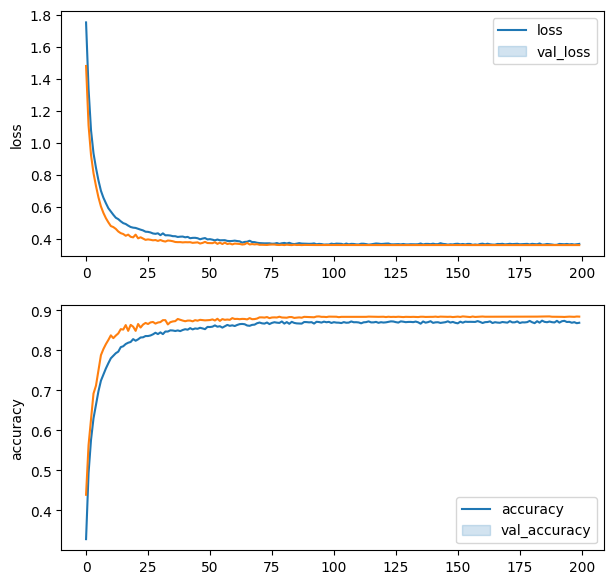

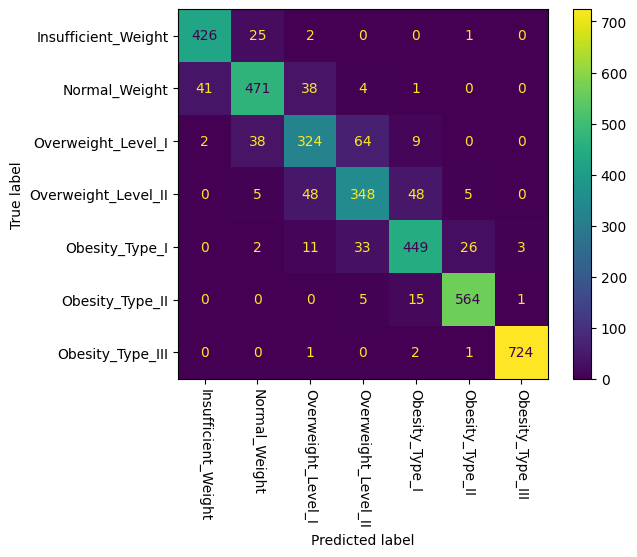

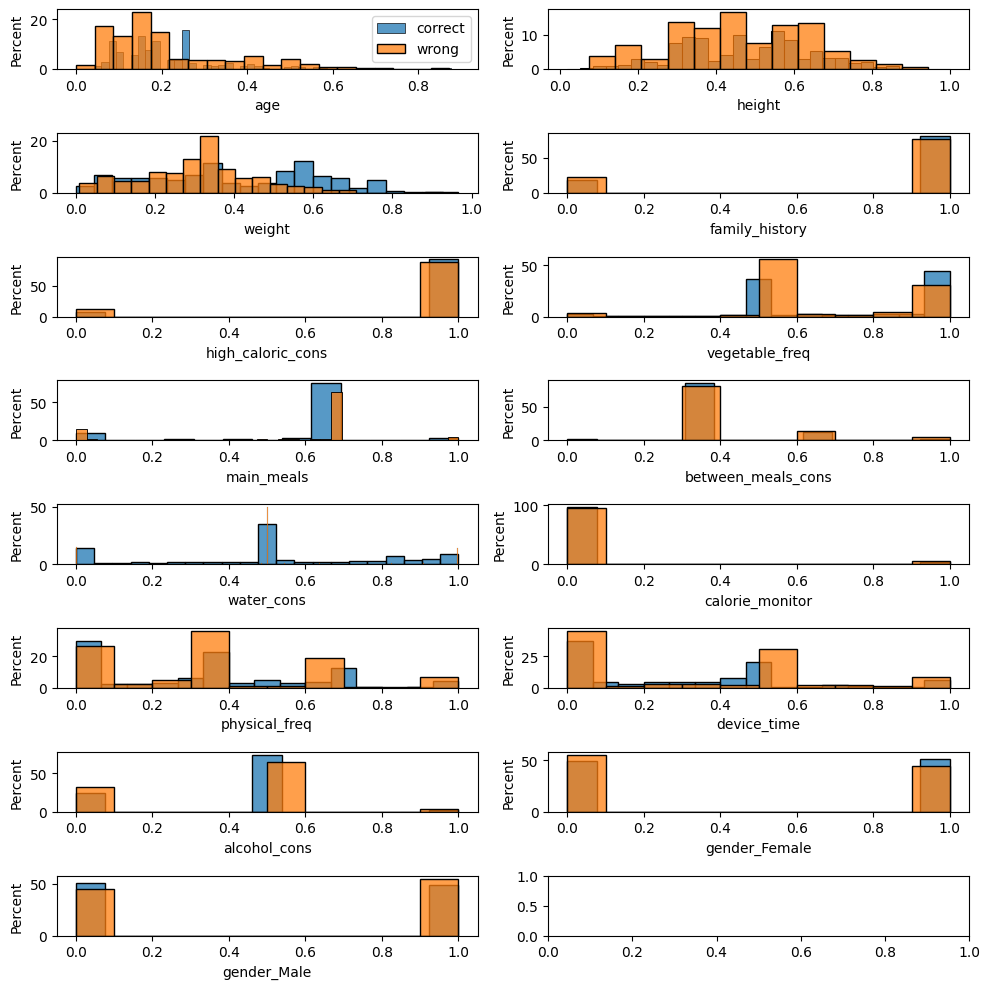

In [165]:
model_smaller = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=[n_features]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model_smaller.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

test_clf_model(model_smaller, callbacks_reduce, X_train_reduced, X_valid_reduced, y_train, y_valid, epochs=200, batch_size=512)

## In the end - still worse than random forests...
Perhaps thats just how the data is.
* It could be a matter of having scaled the data - even though it shouldn't, as the factors proportions should be kept after scaling
* Perhaps a random forest indeed randomly performed extremely well
* In any case, it seems rather easy to group users into a reduced number of groups based on model results

## Let's check the set-out test set performance
as up to this point completely untouchted

In [189]:
X_test_scaled = X_test.copy()

In [190]:
X_test_scaled[X_cols] = scaler_X.transform(X_test[X_cols])

In [192]:
X_test_scaled = X_test_scaled.drop(
    [
    'method_trans_Automobile',
    'method_trans_Bike', 'method_trans_Motorbike',
    'method_trans_Public_Transportation', 'method_trans_Walking'
], axis=1)

In [176]:
X_train, X_valid, y_train, y_valid = train_test_split(X_1, y_1, test_size = 0.2, shuffle=True, stratify=y_1)

In [182]:
print(y_valid['obesity_class'].unique())
print(y_train['obesity_class'].unique())
print(y_test['obesity_class'].unique())

[3 4 1 6 5 0 2]
[5 1 0 3 2 4 6]
[3 6 0 1 2 5 4]


In [178]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_valid)

rf_report = classification_report(y_valid, rf_preds)
print(rf_report)

C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

           0       0.92      0.93      0.92       454
           1       0.82      0.87      0.84       555
           2       0.78      0.70      0.74       437
           3       0.76      0.80      0.78       454
           4       0.89      0.86      0.87       524
           5       0.98      0.98      0.98       585
           6       1.00      0.99      0.99       728

    accuracy                           0.89      3737
   macro avg       0.88      0.88      0.88      3737
weighted avg       0.89      0.89      0.89      3737



Helper function

In [169]:
def test_predictions(model, X_test, y_test, from_proba = False):
    """
    Get classification report, confusion matrix and the distributions of correctly and incorrectly guessed samples
    ---
    Params:
        model - model to test on
        X_test
        y_test
        from_proba - when model is expecte to return probabilities of classes instead of classes
    """

    if from_proba == True:
        y_preds = model.predict(X_test)
        y_preds_argmax = y_preds.argmax(axis=1)
    else:
        y_preds_argmax = model.predict(X_test)
        
    valid_df = X_test.copy()
    valid_df['y_true'] = y_test
    valid_df['y_pred'] = y_preds_argmax
    # preds_df = pd.DataFrame(y_preds)
    # valid_df = valid_df.reset_index()
    # valid_df = pd.concat([valid_df, preds_df], axis=1)

    nn_clf_report = classification_report(y_test, y_preds_argmax, target_names = class_names)
    print(nn_clf_report)

    nn_cm = confusion_matrix(y_test, y_preds_argmax)
    nn_cm_disp = ConfusionMatrixDisplay(nn_cm, display_labels = class_names)
    nn_cm_disp.plot(xticks_rotation=-90)

    wrong_df = valid_df[valid_df['y_true'] != valid_df['y_pred']]
    print(f'wrong shape: {wrong_df.shape}')
    right_df = valid_df[valid_df['y_true'] == valid_df['y_pred']]
    print(f'right shape: {right_df.shape}')

    n_plots = len(X_test.columns)

    fig, axes = plt.subplots(((n_plots + 1) // 2) ,2, figsize=(10,10))
    X_cols = list(X_train.columns)
    right_wrong_cols = [*X_cols, 'y_true', 'y_pred']
    
    ax = axes.ravel()
    
    for i in range(n_plots):
        # sns.histplot(data=df, x=cols_no_stroke[i], hue='stroke', stat='density', ax=ax[i])
        sns.histplot(data = right_df, x=right_wrong_cols[i], stat='percent', ax=ax[i])
        sns.histplot(data = wrong_df, x=right_wrong_cols[i], stat='percent', ax=ax[i])
    ax[0].legend(['correct', 'wrong'], loc='best')
    fig.tight_layout()
    fig.show()

                     precision    recall  f1-score   support

Insufficient_Weight       0.90      0.94      0.92       252
      Normal_Weight       0.83      0.86      0.85       308
 Overweight_Level_I       0.80      0.74      0.77       243
Overweight_Level_II       0.80      0.78      0.79       252
     Obesity_Type_I       0.87      0.87      0.87       291
    Obesity_Type_II       0.95      0.97      0.96       325
   Obesity_Type_III       1.00      1.00      1.00       405

           accuracy                           0.89      2076
          macro avg       0.88      0.88      0.88      2076
       weighted avg       0.89      0.89      0.89      2076

wrong shape: (225, 22)
right shape: (1851, 22)


C:\Users\User\AppData\Local\Temp\ipykernel_9040\3917776210.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


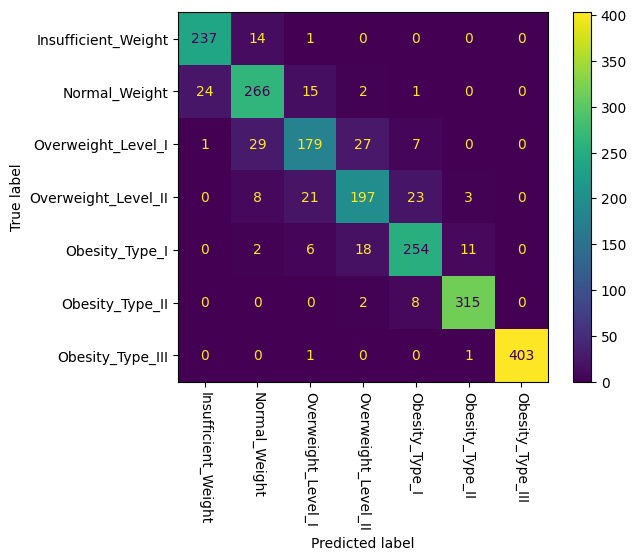

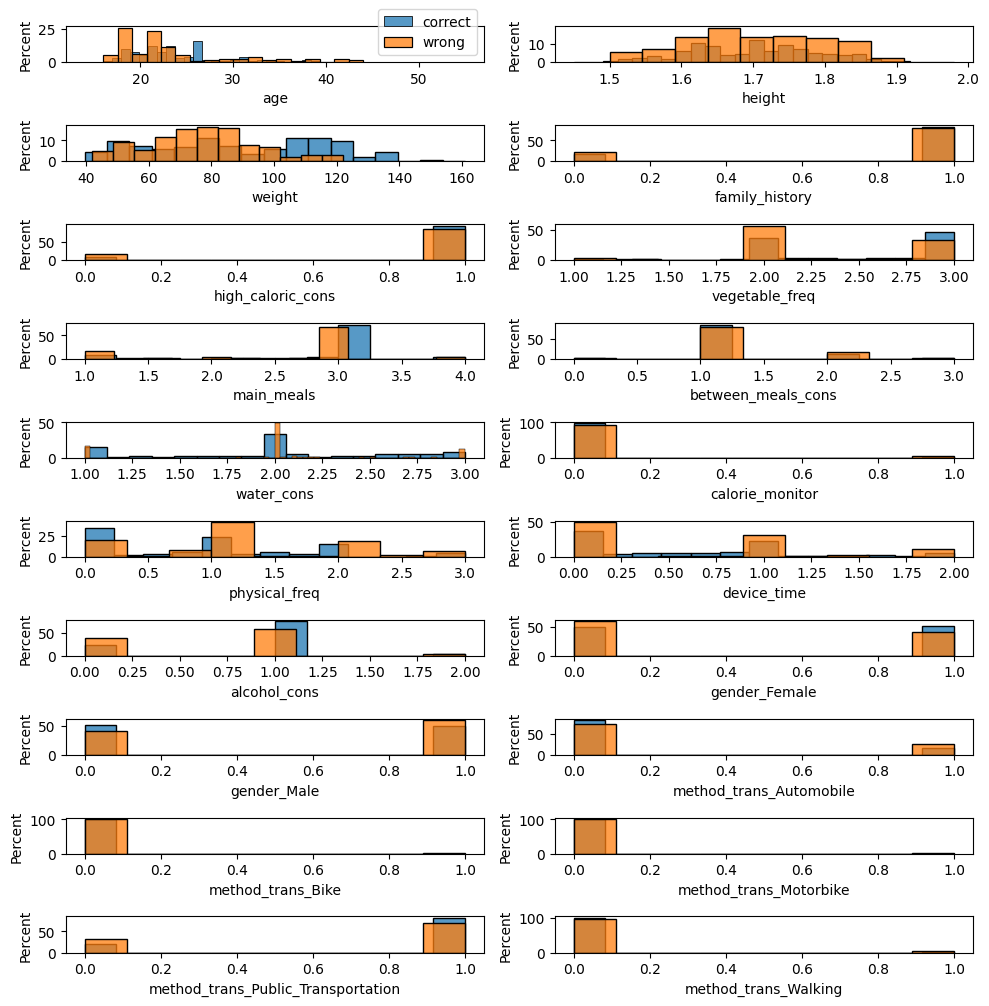

In [183]:
test_predictions(rf_model, X_test, y_test, from_proba=False)

65/65 [==============================] - 0s 812us/step
                     precision    recall  f1-score   support

Insufficient_Weight       0.00      0.00      0.00       252
      Normal_Weight       0.00      0.00      0.00       308
 Overweight_Level_I       0.00      0.00      0.00       243
Overweight_Level_II       0.00      0.00      0.00       252
     Obesity_Type_I       0.00      0.00      0.00       291
    Obesity_Type_II       0.16      1.00      0.28       325
   Obesity_Type_III       1.00      0.10      0.19       405

           accuracy                           0.18      2076
          macro avg       0.17      0.16      0.07      2076
       weighted avg       0.22      0.18      0.08      2076

wrong shape: (1709, 17)
right shape: (367, 17)


C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

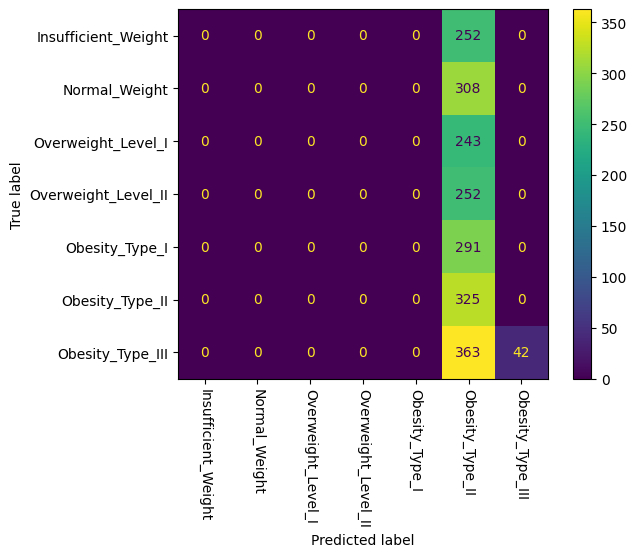

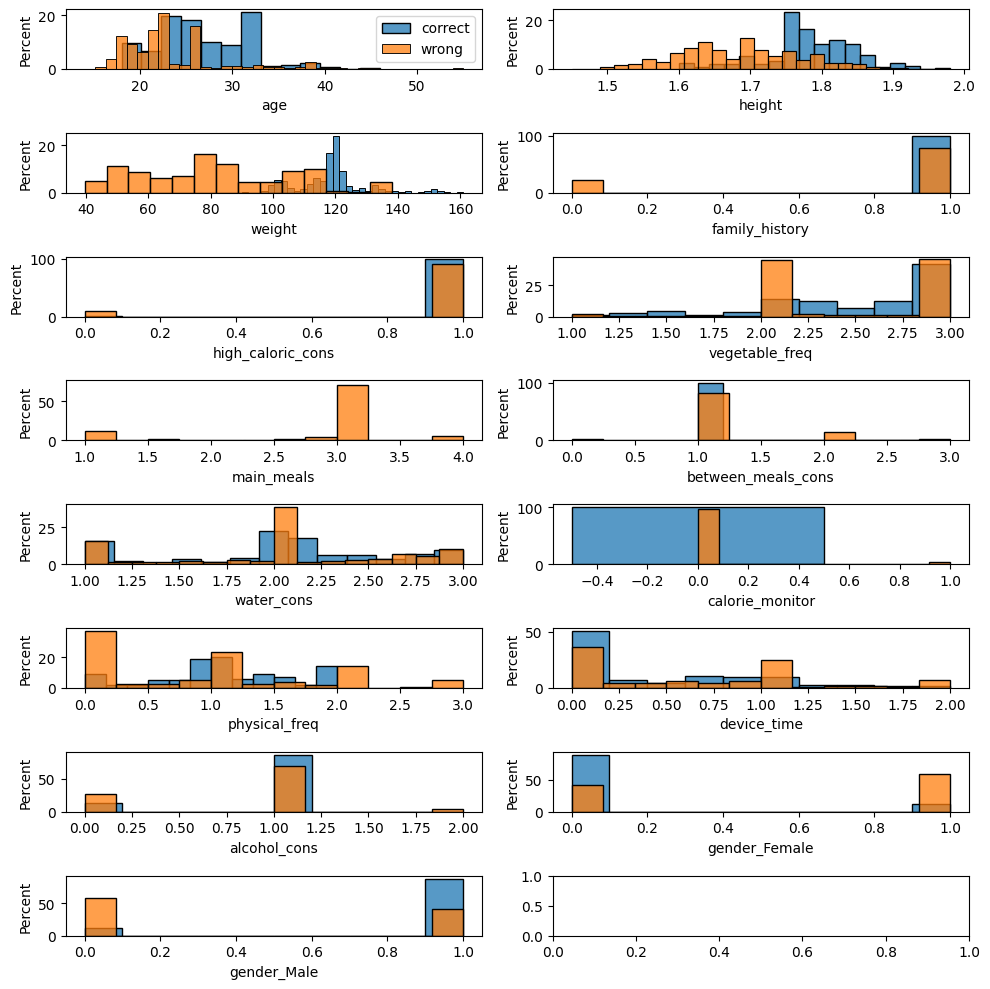

In [194]:
test_predictions(model_smaller, X_test_scaled, y_test, from_proba=True)

What...

In [196]:
model_smaller.predict(X_test_scaled)

65/65 [==============================] - 0s 687us/step


array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.9866702e-04, 9.9980134e-01],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00]], dtype=float32)

## TODO:
* different learning rate
* bring back age and height
* bring back gender
* ...